In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

import itertools
import os

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

import fbprophet

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf

from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import plotly.graph_objects as go
import plotly

plotly.offline.init_notebook_mode(connected=True)

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('pystan').setLevel(logging.ERROR)

import warnings
import sys

warnings.filterwarnings('ignore')
sys.path.append('../functions')

from tsplot import tsplot
from ur_tests import adf_test, kpss_test
from supress import suppress_stdout_stderr

from scipy.stats import norm

figsize = (17, 8)

### Used finctions

MAPE, cross validation ect.

In [10]:
def log_transform(data, inverse=False):
    if inverse == False:
        return np.log1p(data)
    else:
        return np.expm1(data)

In [17]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

def prophet_cross_val(data, param_grid, init_ts='0 days', horizon='30 days', weekly_seasonality=True, holidays=None, c_holidays=None):
    # cutoffs = pd.to_datetime(['2020-10-15', '2020-11-25', '2021-01-15'])

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    rmses = []  # Store the RMSEs for each params here
    mapes = []  # Store the MAPEs
    maes = []   # Store the MAEs
    
    # Use cross validation to evaluate all parameters
    with suppress_stdout_stderr():
        for params in all_params:
            # Train model
            m = Prophet(**params, holidays=holidays, weekly_seasonality=weekly_seasonality, interval_width=0.95)
            
            if c_holidays:
                m.add_country_holidays(country_name=c_holidays)
            
            m.fit(data) 
            # Cross validate
            df_cv = cross_validation(m, initial=init_ts, horizon=horizon, parallel="processes") # cutoffs=cutoffs
            # Get performace metrics
            df_p = performance_metrics(df_cv, metrics=['rmse', 'mae', 'mape'], rolling_window=1)
        
            rmses.append(df_p['rmse'].values[0])
            mapes.append(df_p['mape'].values[0])
            maes.append(df_p['mae'].values[0])
            
    
    # Create table of results
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    tuning_results['mae'] = maes
    tuning_results['mape'] = mapes
    
    best_params = all_params[np.argmin(mapes)]
    best_mape = min(mapes)
    
    print(best_params)
    print(f'Best mape: {best_mape}, Best rmse: {rmses[np.argmin(mapes)]}, Best mae: {maes[np.argmin(mapes)]}')
    
    return tuning_results, best_mape, best_params

def prophet_fit_predict(data, forecast_period=30, growth='linear', changepoints=None, holidays=None, c_holidays=None,
                daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, 
                changepoint_prior_scale=0.5, seasonality_prior_scale=0.1, holidays_prior_scale=0.1,
                seasonality_mode='multiplicative',
                changepoint_range=0.8, interval_width=0.95, mcmc_samples=0, extra_reg=None, custom_s=False):

    
    model = Prophet(growth=growth, holidays=holidays, changepoints=changepoints,
                    daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality, yearly_seasonality=yearly_seasonality,  
                    changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, 
                    seasonality_mode=seasonality_mode, 
                    changepoint_range=changepoint_range, interval_width=interval_width, mcmc_samples=mcmc_samples)
    
    if c_holidays:
        model.add_country_holidays(country_name=c_holidays)
    
    if extra_reg:
        model.add_regressor(extra_reg)
        
    if custom_s:
        model.add_seasonality(name='weekly', period=7, fourier_order=5)
    
    model.fit(data)
    future = model.make_future_dataframe(periods=forecast_period)
    
    if extra_reg:
        forecast = model.predict()
    else:
        forecast = model.predict(future)
    
    return model, forecast

In [5]:
def prophet_best_model(data, forecast_period=14, growth='linear', c_changepoints=None, holidays=None, c_holidays=None,
                                    daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                    changepoint_prior_scale=1.0, seasonality_prior_scale=0.1, holidays_prior_scale=1.0, 
                                    seasonality_mode='additive', 
                                    changepoint_range=0.95, interval_width=0.95, mcmc_samples=0, extra_reg=None, custom_s=False):
    
    model, forecast = prophet_fit_predict(data=data[:-14], forecast_period=forecast_period, growth=growth, changepoints=c_changepoints, holidays=holidays, c_holidays=c_holidays,
                                      daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality, yearly_seasonality=yearly_seasonality,  
                                      changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, 
                                      seasonality_mode=seasonality_mode, 
                                      changepoint_range=changepoint_range, interval_width=interval_width, mcmc_samples=mcmc_samples, extra_reg=extra_reg, custom_s=custom_s)
    # Cross validation of model
#     df_cv = cross_validation(model, initial='100 days', horizon='14 days', parallel="processes")
#     # Calculation of performace metrics
#     df_p = performance_metrics(df_cv, metrics=['rmse', 'mae', 'mape'], rolling_window=1)
#     # Plot metric values
#     fig = plot_cross_validation_metric(df_cv, metric='mape', figsize=figsize)
    
#     # Print metrics
#     print(f'RMSE: {df_p["rmse"].values[0]}, MAE: {df_p["mae"].values[0]}, MAPE: {df_p["mape"].values[0]}')
    print('MAPE on test data: {m:.3f}%'.format(m=mape(data["y"][-14:], forecast["yhat"][-14:])))
    # Plot summary graphs
    fig = model.plot(forecast, figsize=figsize)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
    fig = model.plot_components(forecast, figsize=figsize)
    
    changepoints = c_changepoints
    
    if c_changepoints is None:
        # Print changepoints
        changepoints = pd.DataFrame(model.changepoints)
        print(changepoints.index)
        changepoints = changepoints.reset_index().drop(['index'], axis=1)
    # display(changepoints)
    return model, forecast, changepoints
    
def prophet_best_slice(data, changepoints, predict_depth=14, 
                                          growth='linear', holidays=None, c_holidays=None,
                                          daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                          changepoint_prior_scale=1.0, seasonality_prior_scale=0.1, holidays_prior_scale=1.0, 
                                          seasonality_mode='additive', 
                                          changepoint_range=0.95, interval_width=0.95, mcmc_samples=0):
        
    models = []
    mapes = []
    
    for c in changepoints:
        d_train = data[c:-predict_depth]
        d_test = data[-predict_depth:]
    
        ## From chekpoint
        model, forecast = prophet_fit_predict(data=d_train, forecast_period=predict_depth, growth=growth, holidays=holidays, c_holidays=c_holidays,
                                          daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality, yearly_seasonality=yearly_seasonality,  
                                          changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale, 
                                          seasonality_mode=seasonality_mode, 
                                          changepoint_range=changepoint_range, interval_width=interval_width, mcmc_samples=mcmc_samples)
        # Print metrics
        print(f'From changepoint = {c} info:')
        print(f'MAPE train: {mape(d_train.y, forecast.yhat[:-predict_depth])}, MAPE test: {mape(d_test.y, forecast.yhat[-predict_depth:])}')
        
        models.append((model, forecast))
        mapes.append(mape(d_test.y, forecast.yhat[-predict_depth:]))
        
    return models, mapes

In [6]:
def plot_forecast_slice(data, forecast, changepoint, forecast_horizon=14, title='', plt_save_path='../figures/'):
    forecast_slice = forecast[['yhat_lower', 'yhat_upper', 'yhat', 'ds']][changepoint:]
    print('MAPE on test data: {m:.3f}%'.format(m=mape(data["y"][-14:], forecast_slice["yhat"][-14:])))

    fig = plt.figure(figsize=(17,8))

    plt.plot(forecast_slice['ds'][:-13], forecast_slice['yhat'][:-13], color='blue', label='Modeled data')
    plt.plot(forecast_slice['ds'][-14:], forecast_slice['yhat'][-14:], color='blue', label='Forecasted data')

    plt.fill_between(forecast_slice['ds'], forecast_slice['yhat_lower'], forecast_slice['yhat_upper'], color='lightblue')

    plt.plot(data['ds'][changepoint:-13], data['y'][changepoint:-13], color='red', label='Real train data')
    plt.plot(data['ds'][-14:], data['y'][-14:], color='orange', label='Real test data')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.savefig(plt_save_path)
    plt.show()

## Loading data

#### For full step-by-step analysis according to the structure of bechelor thesis i've decided to choose time series, that describes comulative amount of people infected.

#### In this notebook i've used data, downloaded during 04.05


In [2]:
# Read dataframe
data = pd.read_csv('../data/nakazeni-vyleceni-umrti-testy-04-05.csv')
# Convert data to proper data type
data['datum'] = pd.to_datetime(data['datum'])
# Display first 5 rows
data.head(5)

,datum,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti,kumulativni_pocet_testu,kumulativni_pocet_ag_testu
0,2020-01-27,0,0,0,20,0
1,2020-01-28,0,0,0,28,0
2,2020-01-29,0,0,0,33,0
3,2020-01-30,0,0,0,34,0
4,2020-01-31,0,0,0,37,0


#### Thanks to fact, that this time series was selected from data set, that containes public information and has high consistancy level, we dont need to deal with missing values and other problems with real world data.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datum                         463 non-null    datetime64[ns]
 1   kumulativni_pocet_nakazenych  463 non-null    int64         
 2   kumulativni_pocet_vylecenych  463 non-null    int64         
 3   kumulativni_pocet_umrti       463 non-null    int64         
 4   kumulativni_pocet_testu       463 non-null    int64         
 5   kumulativni_pocet_ag_testu    463 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 21.8 KB


## Data preparation

#### So in this section i simply created separated data frame for selected time series.

#### I also tranformed it into requested representation for usage in Prophet model. 
That means, that i've created datframe with 'ds' and 'y' columns, where:
- 'ds' - date, when observation had happened.
- 'y' - value of observed variable


In [4]:
data['active'] = data['kumulativni_pocet_nakazenych'] - data['kumulativni_pocet_vylecenych'] - data['kumulativni_pocet_umrti']
# Infected
infected = data[['datum', 'kumulativni_pocet_nakazenych']].rename({'kumulativni_pocet_nakazenych': 'y', 'datum': 'ds'}, axis=1)
# Cured
cured = data[['datum', 'kumulativni_pocet_vylecenych']].rename({'kumulativni_pocet_vylecenych': 'y', 'datum': 'ds'}, axis=1)
# Dead
dead = data[['datum', 'kumulativni_pocet_umrti']].rename({'kumulativni_pocet_umrti': 'y', 'datum': 'ds'}, axis=1)
# Tests
tests = data[['datum', 'kumulativni_pocet_testu']].rename({'kumulativni_pocet_testu': 'y', 'datum': 'ds'}, axis=1)
# Active = Infected - cured - dead
active = data[['datum', 'active']].rename({'active': 'y', 'datum': 'ds'}, axis=1)

### Drop first zero measurements (equal amount)

In [5]:
infected = infected[55:]
dead = dead[55:]
cured = cured[55:]
active = active[55:]

In [8]:
infected = infected.reset_index().drop(['index'], axis=1)
cured = cured.reset_index().drop(['index'], axis=1)
dead = dead.reset_index().drop(['index'], axis=1)
active = active.reset_index().drop(['index'], axis=1)

In [11]:
# Apply log transform to the active cases time series
active_log = active.copy()
active_log['y'] = log_transform(active_log['y'], inverse=False)

## Prophet modelling

First of all we need to estimate the best parameters for our Prophet model.

For this purpose, i've decided to use cross validation with parameter grid specified below.

In result, i've got next parameters:
- changepoint_prior_scale = 0.8
- seasonality_prior_scale = 10.0
- seasonality_mode = additive
- changepoint_range = 0.99

But in order to handle potential model overfitting due to huge changepoint range, i've decided to check 0.95 too.

#### Cross validation

In [23]:
# Parameter grid with Prophet model hyperparams
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.5, 0.8, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_range': [0.8, 0.90, 0.95]
}
param_grid_dead = {  
    'changepoint_prior_scale': [0.1, 0.5, 0.8, 1.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.90, 0.95]
}

In [23]:
tuning_results_i, best_mape_i, best_params_i = prophet_cross_val(infected[:-14], param_grid, init_ts='150 days', horizon='14 days', weekly_seasonality=True, c_holidays='CZ')

{'changepoint_prior_scale': 0.8, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
Best mape: 0.0531444579012088, Best rmse: 29212.563270872386, Best mae: 161


In [24]:
tuning_results_c, best_mape_c, best_params_c = prophet_cross_val(cured[:-14], param_grid, init_ts='150 days', horizon='14 days', weekly_seasonality=True, c_holidays='CZ')

{'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
Best mape: 0.053814710903612735, Best rmse: 25359.521253752835, Best mae: 197


In [25]:
tuning_results_d, best_mape_d, best_params_d = prophet_cross_val(dead[:-14], param_grid_dead, init_ts='150 days', horizon='14 days', weekly_seasonality=False, c_holidays='CZ')

{'changepoint_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.95}
Best mape: 0.05111706993647446, Best rmse: 400.2015710453892, Best mae: 32


In [26]:
tuning_results_a, best_mape_a, best_params_a = prophet_cross_val(active_log[:-14], param_grid, init_ts='150 days', horizon='14 days', weekly_seasonality=True, c_holidays='CZ')

{'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
Best mape: 0.024551992842975514, Best rmse: 0.34707454691768397, Best mae: 0.26851426642818577


### Fit best models

MAPE on test data: 0.818%
Int64Index([ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373],
           dtype='int64')


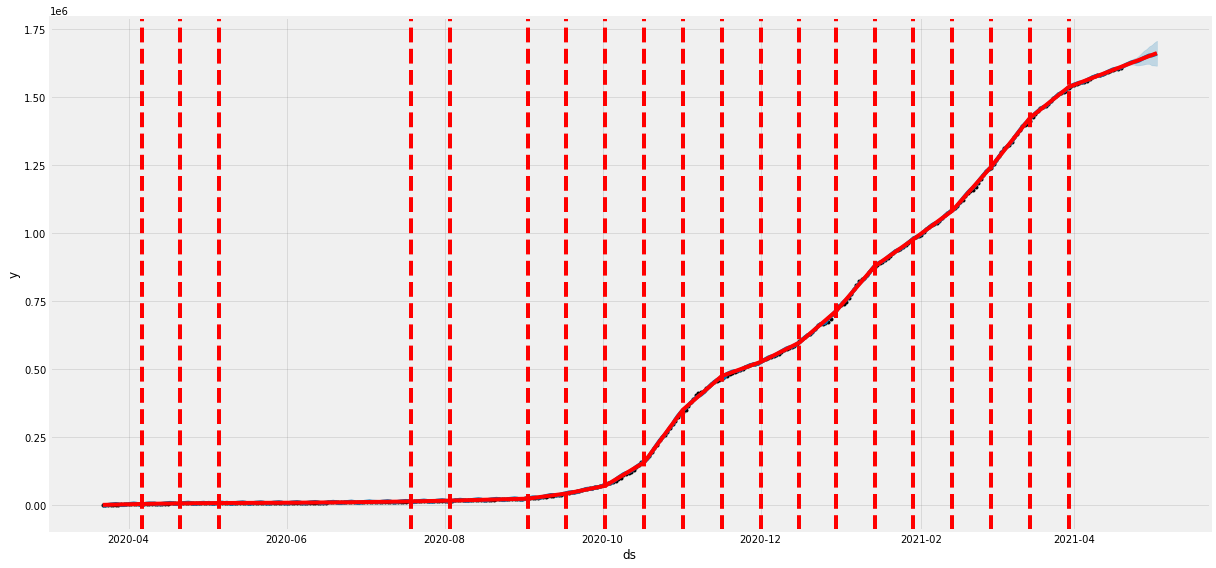

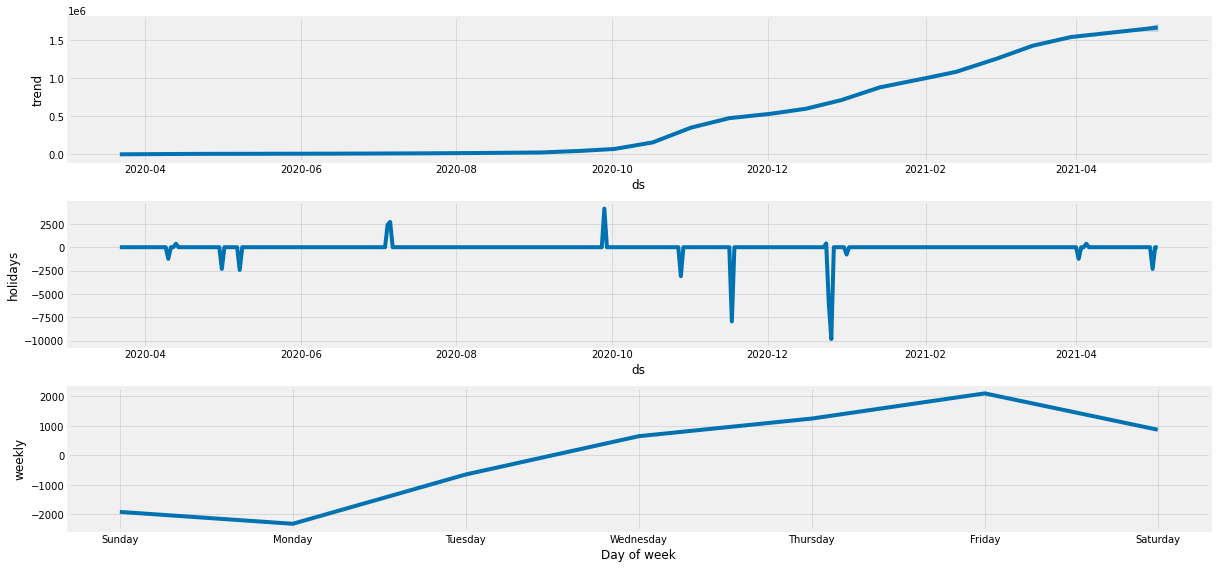

In [358]:
model_i_o, forecast_i_o, changepoints_i_o = prophet_best_model(data=infected, forecast_period=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                      changepoint_prior_scale=0.8, seasonality_prior_scale=10.0, holidays_prior_scale=10.0, 
                                      seasonality_mode='additive', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=0)

MAPE on test data: 0.823%


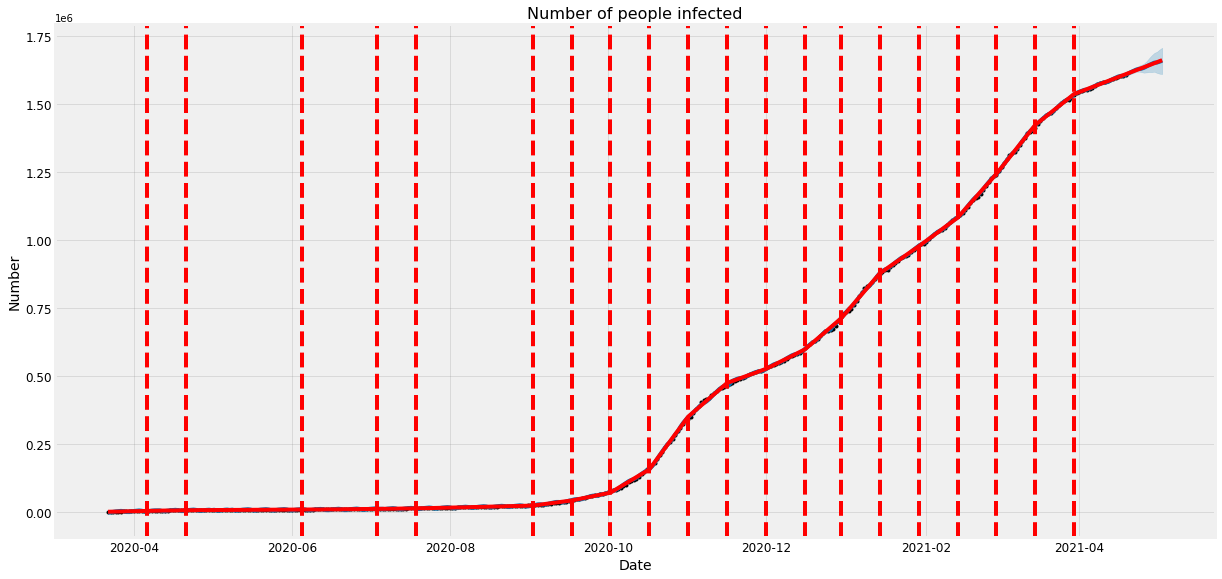

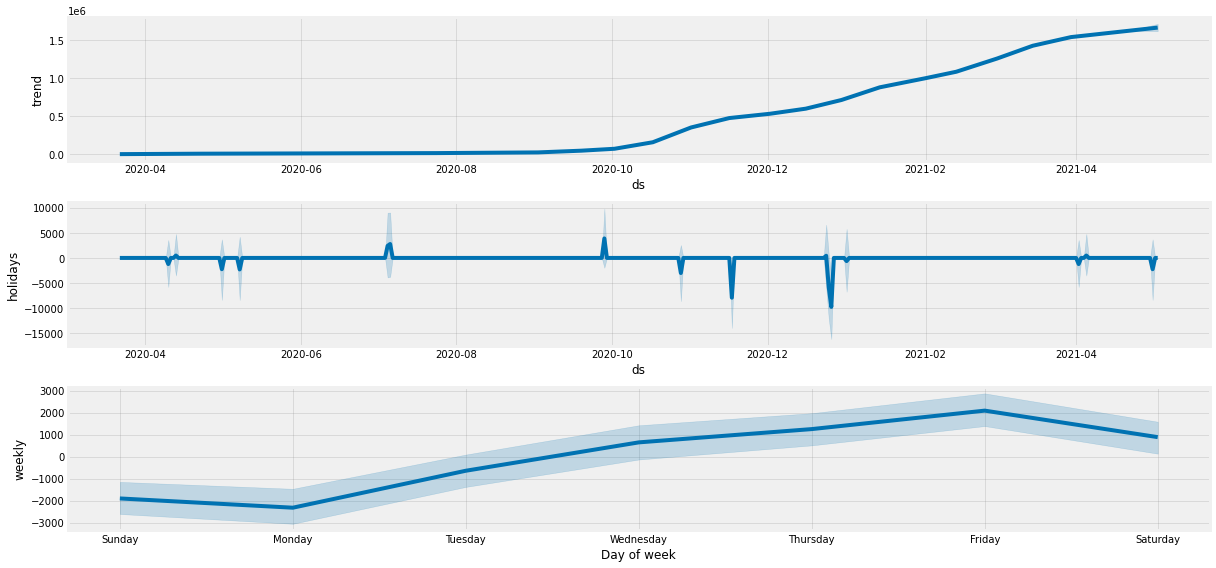

In [211]:
print('MAPE on test data: {m:.3f}%'.format(m=mape(infected["y"][-14:], forecast_i_o["yhat"][-14:])))
# Plot summary graphs
fig = model_i_o.plot(forecast_i_o, figsize=figsize)
ax = fig.gca()
ax.set_title("Number of people infected", size=16)
ax.set_xlabel("Date", size=14)
ax.set_ylabel("Number", size=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
# print(ax.legend())

a = add_changepoints_to_plot(fig.gca(), model_i_o, forecast_i_o)
# plt.savefig('../figures/infected_fbp_modeled.png')
fig = model_i_o.plot_components(forecast_i_o, figsize=figsize)
ax = fig.gca()
# ax.set_title("Camulative number of people infected: forecast components", size=16)
# plt.savefig('../figures/infected_fbp_components.png')

MAPE on test data: 0.823%


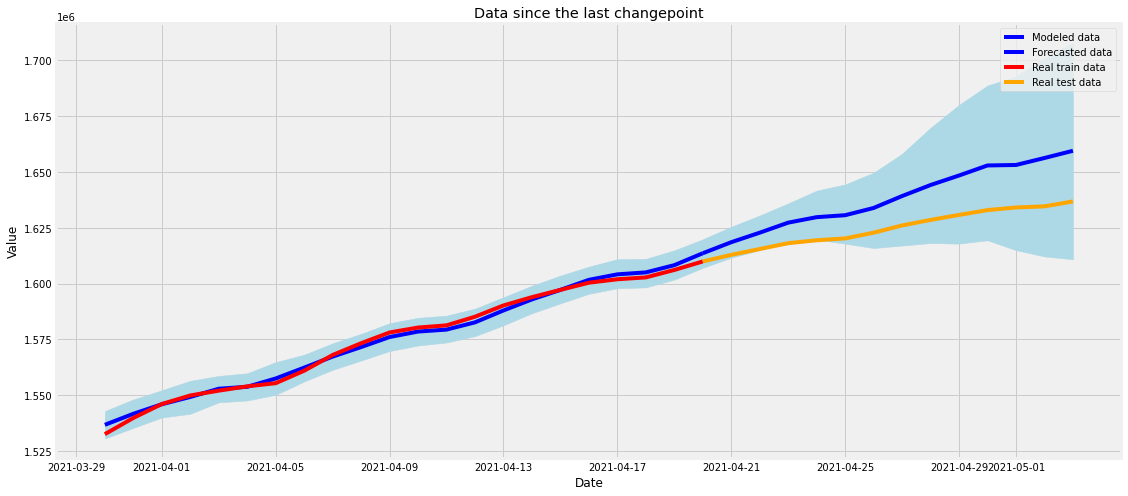

In [213]:
plot_forecast_slice(infected, forecast_i_o, 373, forecast_horizon=14, title='Data since the last changepoint', plt_save_path='../figures/forecast_infected_fff.png')

MAPE on test data: 1.534%
Int64Index([ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373],
           dtype='int64')


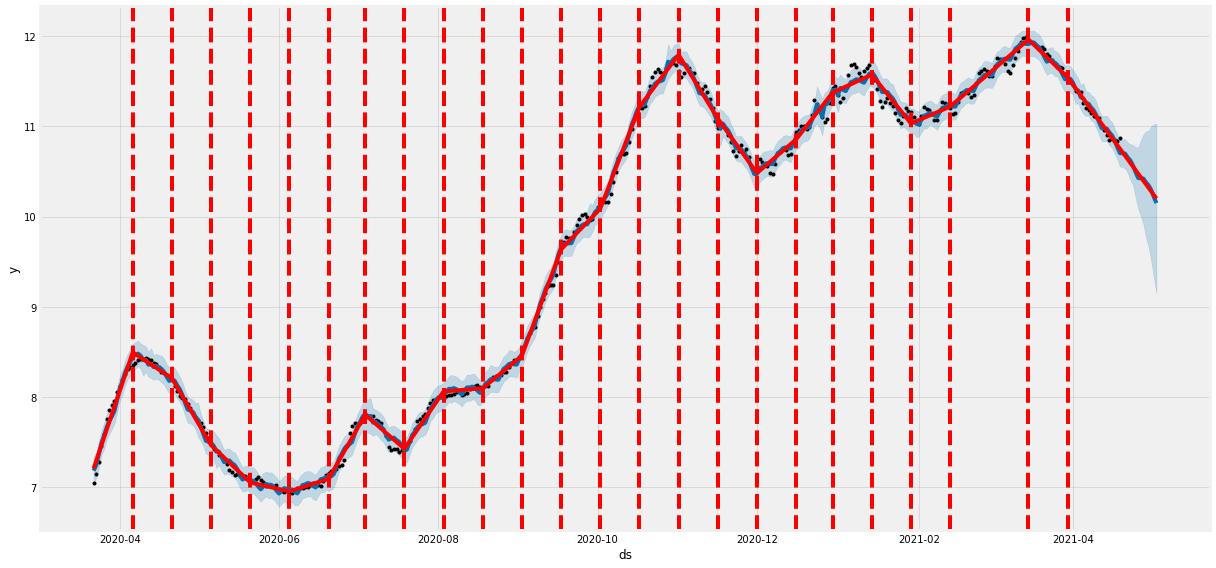

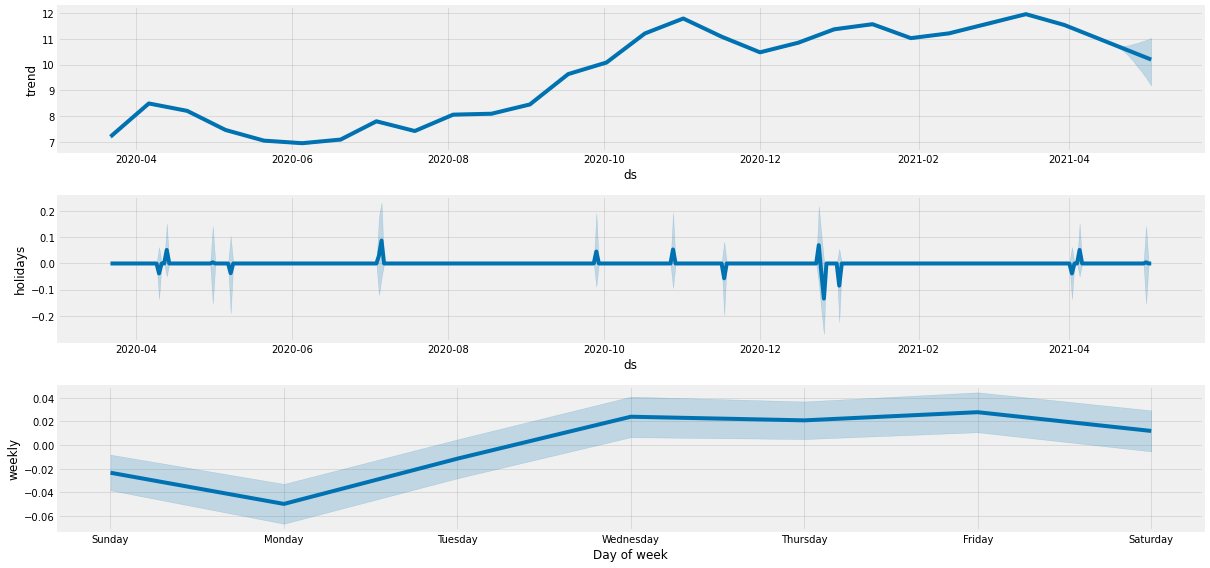

In [27]:
model_a, forecast_a, changepoints_a = prophet_best_model(data=active_log, forecast_period=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                      changepoint_prior_scale=1.0, seasonality_prior_scale=10.0, holidays_prior_scale=10.0, 
                                      seasonality_mode='additive', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=500)

In [28]:
forecast_a_inversed = forecast_a.copy()
# forecast_a_inversed[['']] = fore

for c in forecast_a_inversed.columns:
    if c !='ds':
        forecast_a_inversed[c] = log_transform(forecast_a_inversed[c], inverse=True)

MAPE on test data: 14.307%


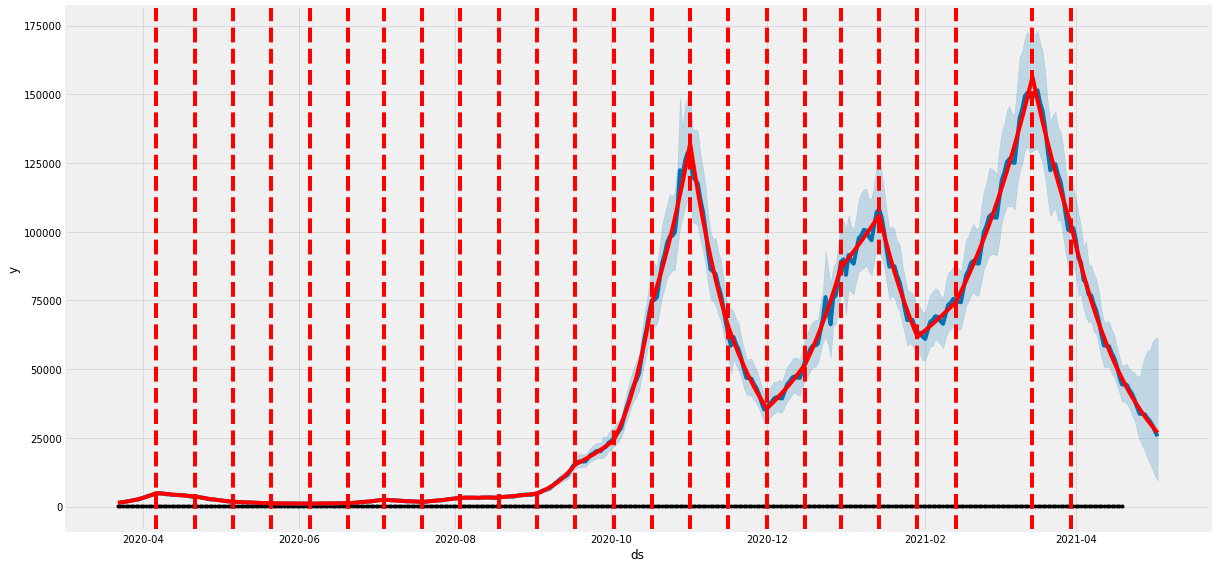

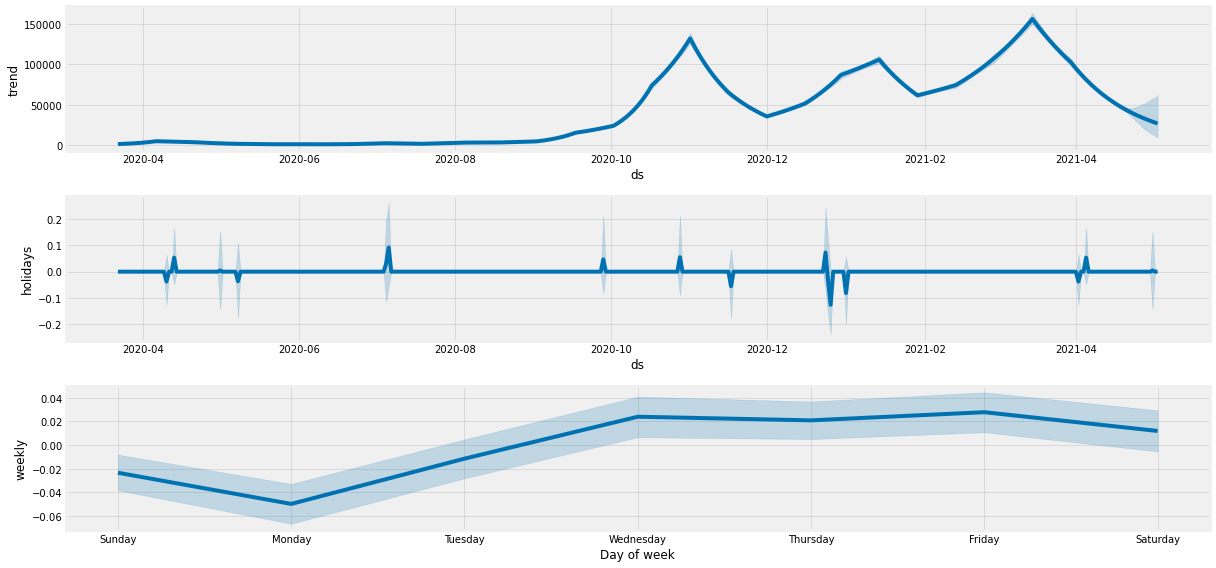

In [29]:
print('MAPE on test data: {m:.3f}%'.format(m=mape(active["y"][-14:], forecast_a_inversed["yhat"][-14:])))
# Plot summary graphs
fig = model_a.plot(forecast_a_inversed, figsize=figsize)
a = add_changepoints_to_plot(fig.gca(), model_a, forecast_a_inversed)
fig = model_a.plot_components(forecast_a_inversed, figsize=figsize)

MAPE on test data: 14.307%


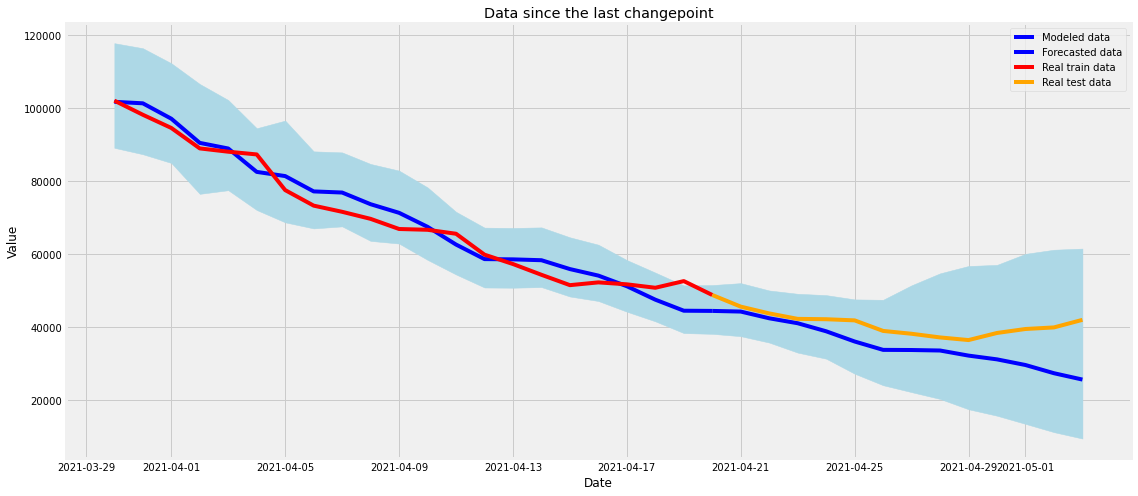

In [116]:
plot_forecast_slice(active, forecast_a_inversed, 373, forecast_horizon=14, title='Data since the last changepoint', plt_save_path='../figures/forecast_active_fc.png')

MAPE on test data: 1.591%
Int64Index([ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373],
           dtype='int64')


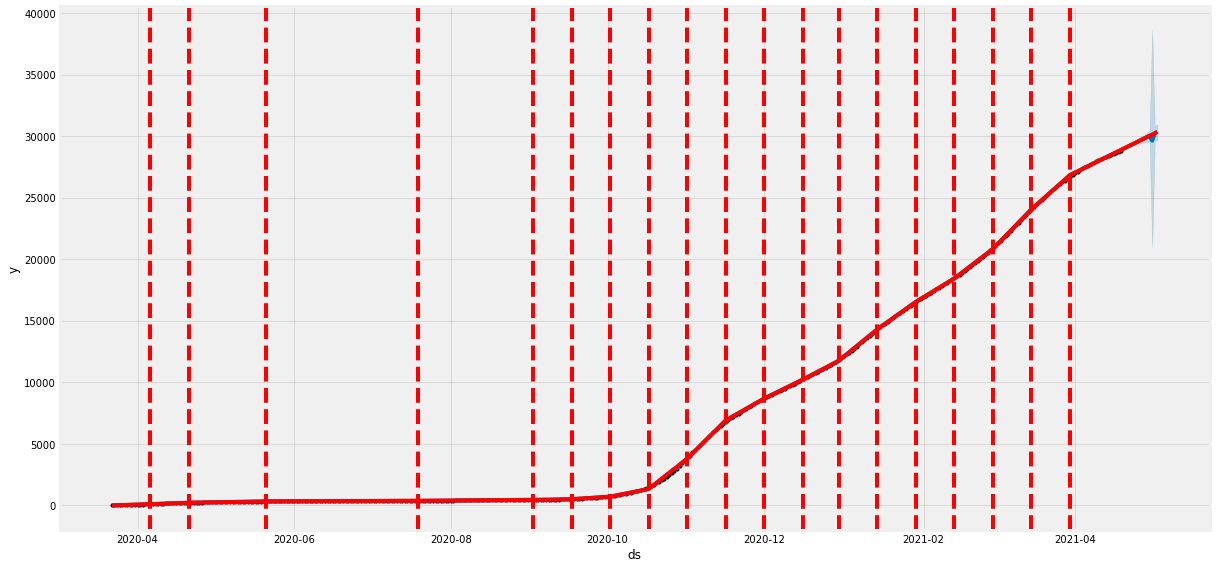

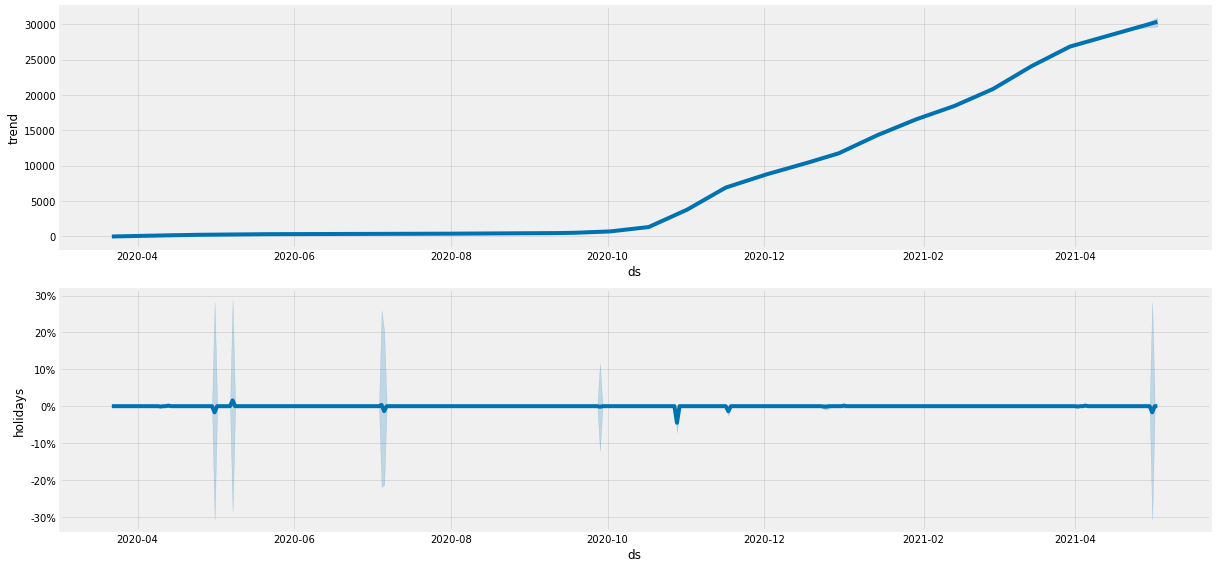

In [117]:
model_d, forecast_d, changepoints_d = prophet_best_model(data=dead, forecast_period=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,  
                                      changepoint_prior_scale=1.0, seasonality_prior_scale=10.0, holidays_prior_scale=1.0, 
                                      seasonality_mode='multiplicative', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=500)

MAPE on test data: 1.591%


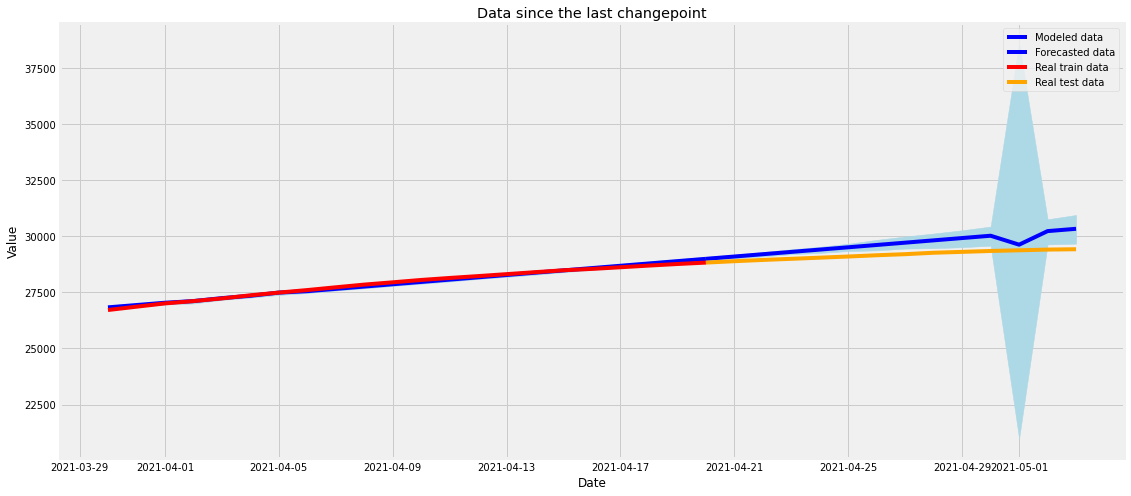

In [118]:
plot_forecast_slice(dead, forecast_d, 373, forecast_horizon=14, title='Data since the last changepoint', plt_save_path='../figures/forecast_dead_fc.png')

MAPE on test data: 2.143%
Int64Index([ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373],
           dtype='int64')


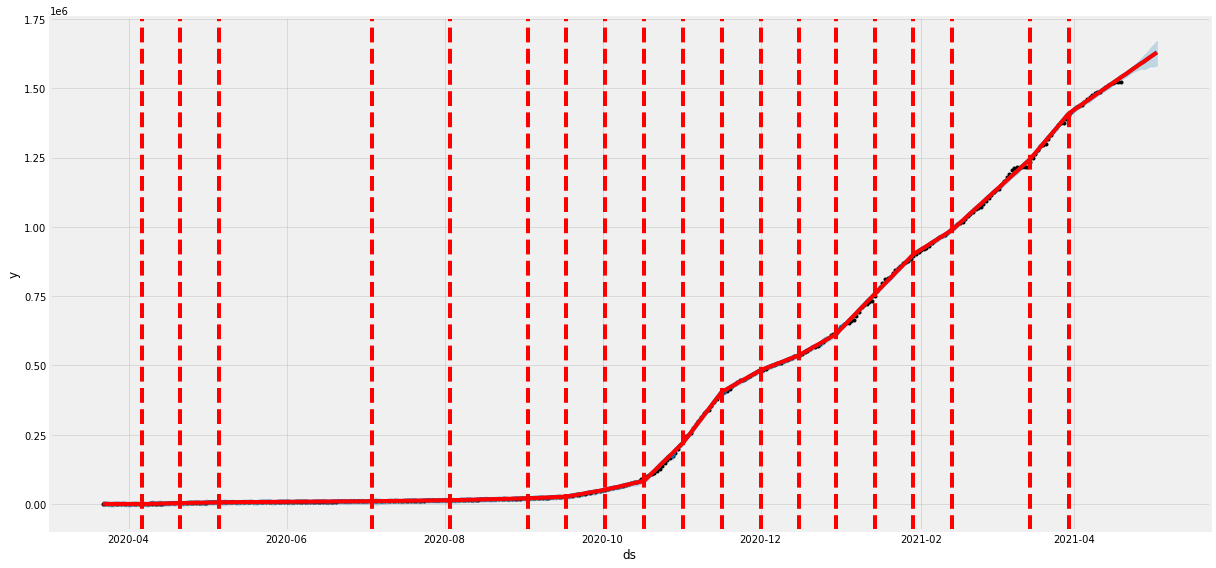

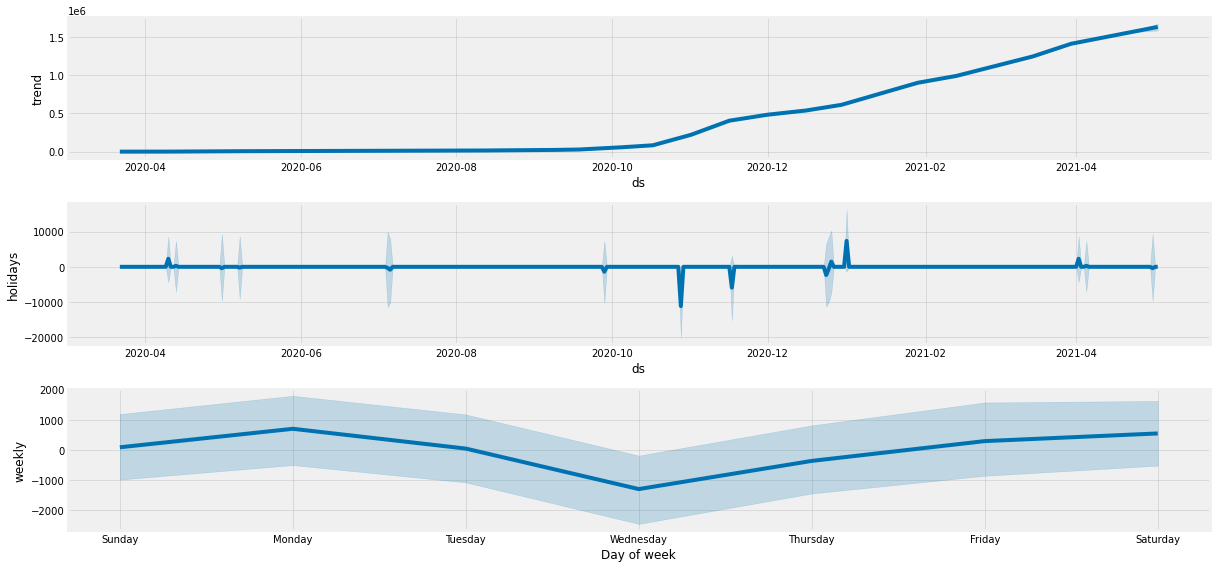

In [119]:
model_c, forecast_c, changepoints_c = prophet_best_model(data=cured, forecast_period=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                      changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, holidays_prior_scale=10.0, 
                                      seasonality_mode='additive', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=500)

MAPE on test data: 2.143%


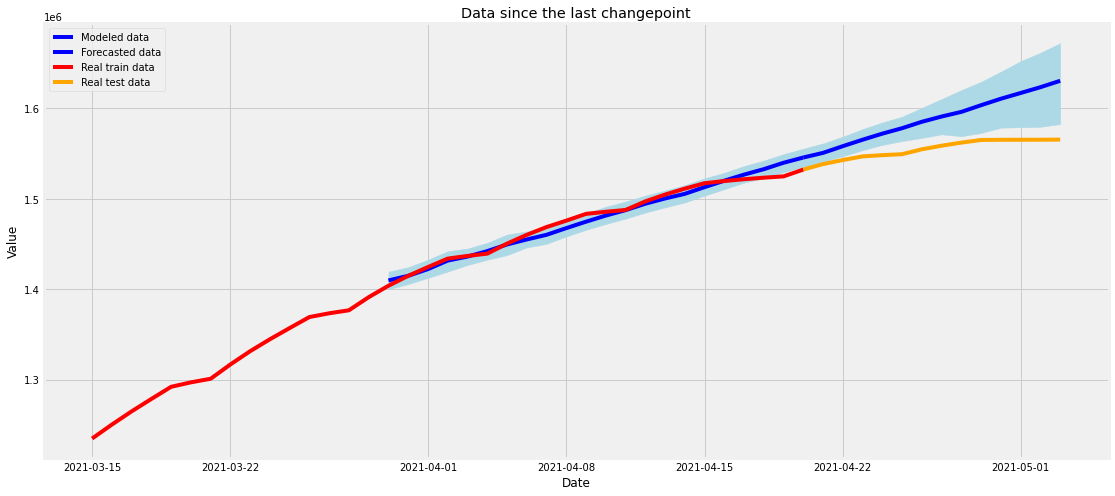

In [122]:
plot_forecast_slice(cured, forecast_c, 358, forecast_horizon=14, title='Data since the last changepoint', plt_save_path='../figures/forecast_cured_fc.png')

### Changepoints drom different ts comparation
All potential changepoints are the same


In [139]:
changepoints_i_index = [ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]
changepoints_a_index = [ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]
changepoints_d_index = [ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]
changepoints_c_index = [ 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

#### Best changepoint selection INFECTED

After training first model, i decided to select changepoint, training on data from which will give us the loweet MAPE error on test data

In [143]:
changepoints_i_i = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

models_i, mapes_i = prophet_best_slice(infected, changepoints_i_i, predict_depth=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                      changepoint_prior_scale=0.8, seasonality_prior_scale=10.0, holidays_prior_scale=10.0, 
                                      seasonality_mode='additive', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=0)

From changepoint = 15 info:
MAPE train: 5.274014507949914, MAPE test: 0.7665715041009403
From changepoint = 30 info:
MAPE train: 4.613198347456639, MAPE test: 0.7618744377923009
From changepoint = 45 info:
MAPE train: 4.202933502161926, MAPE test: 0.7262440504551557
From changepoint = 60 info:
MAPE train: 3.946846075573791, MAPE test: 0.6529001701520071
From changepoint = 75 info:
MAPE train: 3.440499522930943, MAPE test: 0.6317123927181549
From changepoint = 90 info:
MAPE train: 2.9115136464563642, MAPE test: 0.6596234291563023
From changepoint = 104 info:
MAPE train: 2.5712393447679927, MAPE test: 0.6272927225339986
From changepoint = 119 info:
MAPE train: 2.2764007448104504, MAPE test: 0.6147134993142426
From changepoint = 134 info:
MAPE train: 1.7367268865990275, MAPE test: 0.6132833310972085
From changepoint = 149 info:
MAPE train: 1.2980915039123573, MAPE test: 0.6276700447777019
From changepoint = 164 info:
MAPE train: 0.8152933100195454, MAPE test: 0.6248322251300903
From chang

#### The best changepoint is with index = 91 and gives MAPE = 0.339%

In [194]:
print('MAPE on test data: {m:.3f}%'.format(m=mape(infected["y"][-14:], best_forecast_i["yhat"][-14:])))

MAPE on test data: 0.339%


Min MAPE: 0.3391493023179624


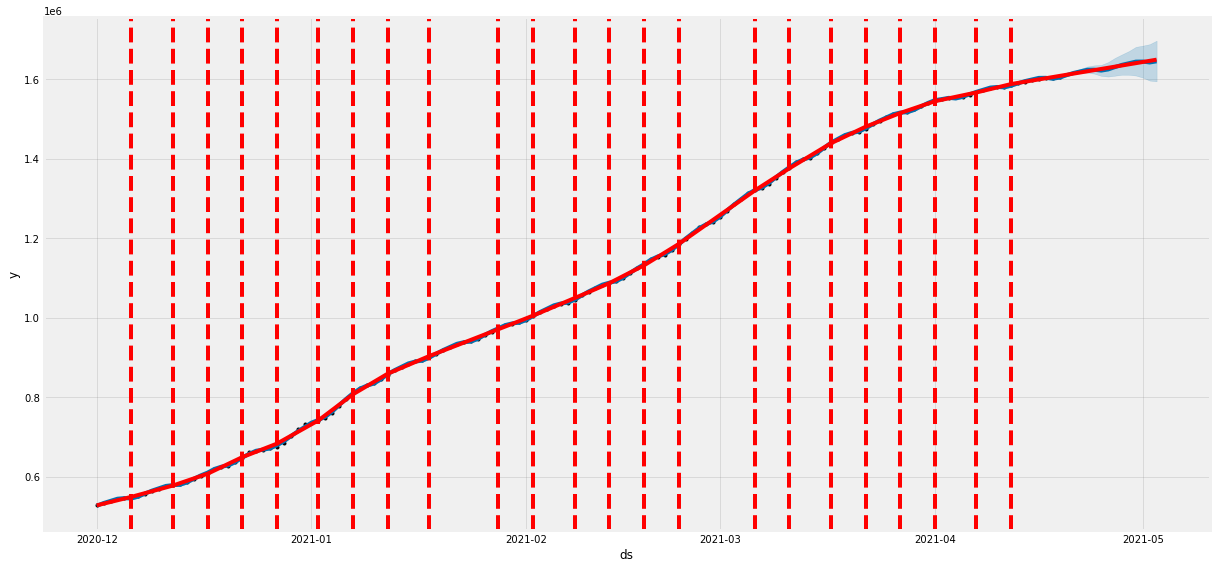

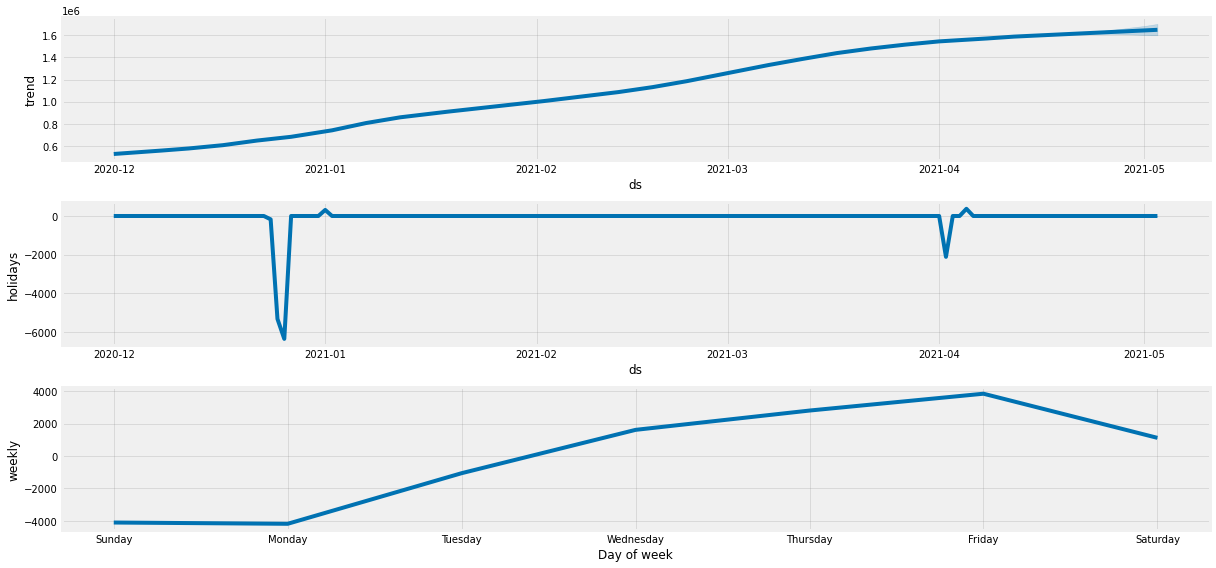

In [144]:
print(f'Min MAPE: {min(mapes_i)}')
best_model_i, best_forecast_i = models_i[np.argmin(mapes_i)]
# Plot summary graphs
fig = best_model_i.plot(best_forecast_i, figsize=figsize)
a = add_changepoints_to_plot(fig.gca(), best_model_i, best_forecast_i)
fig = best_model_i.plot_components(best_forecast_i, figsize=figsize)

MAPE on test data: 0.339%


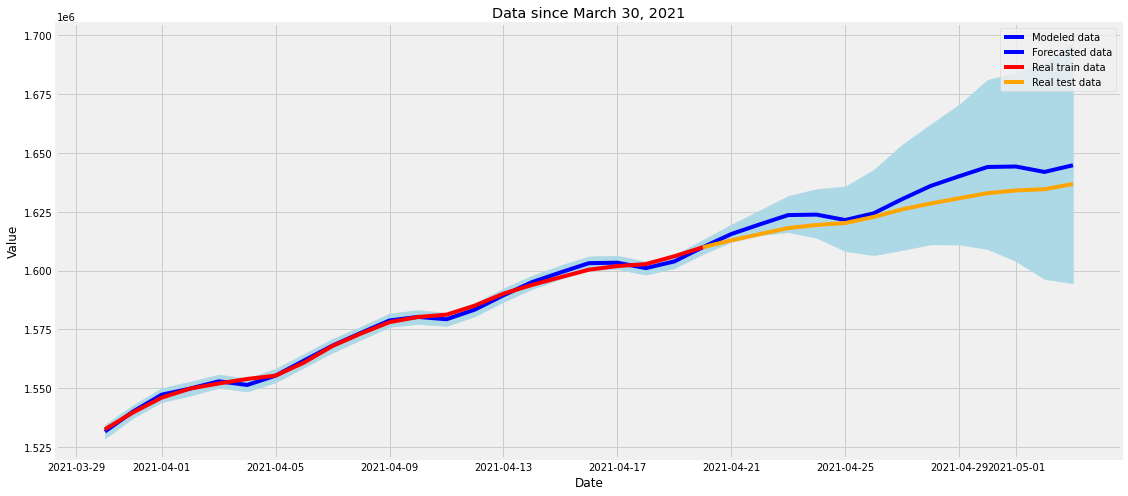

In [202]:
plot_forecast_slice(infected[254:], best_forecast_i, -35, forecast_horizon=14, title='Data since March 30, 2021', plt_save_path='../figures/forecast_infected_b_fc.png')

#### Best changepoint selection ACTIVE

In [157]:
changepoints_i_i = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

models_a, mapes_a = prophet_best_slice(active_log, changepoints_i_i, predict_depth=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                      changepoint_prior_scale=1.0, seasonality_prior_scale=10.0, holidays_prior_scale=10.0, 
                                      seasonality_mode='additive', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=0)

From changepoint = 0 info:
MAPE train: 0.5363487578139974, MAPE test: 1.5290566926791402
From changepoint = 15 info:
MAPE train: 0.5271776758646537, MAPE test: 1.3404772042925033
From changepoint = 30 info:
MAPE train: 0.5838471721855488, MAPE test: 1.3548627180015274
From changepoint = 45 info:
MAPE train: 0.5923345907638882, MAPE test: 1.2606259497425307
From changepoint = 60 info:
MAPE train: 0.6160922467743526, MAPE test: 1.1659801059602033
From changepoint = 75 info:
MAPE train: 0.5052471886668303, MAPE test: 1.053782098730078
From changepoint = 90 info:
MAPE train: 0.4907756259201957, MAPE test: 1.0619164093222981
From changepoint = 104 info:
MAPE train: 0.4249993855492895, MAPE test: 1.0539404197164877
From changepoint = 119 info:
MAPE train: 0.3609491282986908, MAPE test: 0.9602344535453241
From changepoint = 134 info:
MAPE train: 0.3539747752317663, MAPE test: 0.8577484797015374
From changepoint = 149 info:
MAPE train: 0.34191638088499365, MAPE test: 0.84147587624719
From chan

#### The best changepoint is with index = 179 and gives MAPE = 7,9%

In [195]:
print(np.argmin(mapes_a), np.min(mapes_a))
best_model_a, best_forecast_a = models_a[np.argmin(mapes_a)]

12 0.7829747985943667


In [161]:
best_forecast_a_inversed = best_forecast_a.copy()
# forecast_a_inversed[['']] = fore

for c in best_forecast_a_inversed.columns:
    if c !='ds':
        best_forecast_a_inversed[c] = log_transform(best_forecast_a_inversed[c], inverse=True)

MAPE on test data: 7.993%


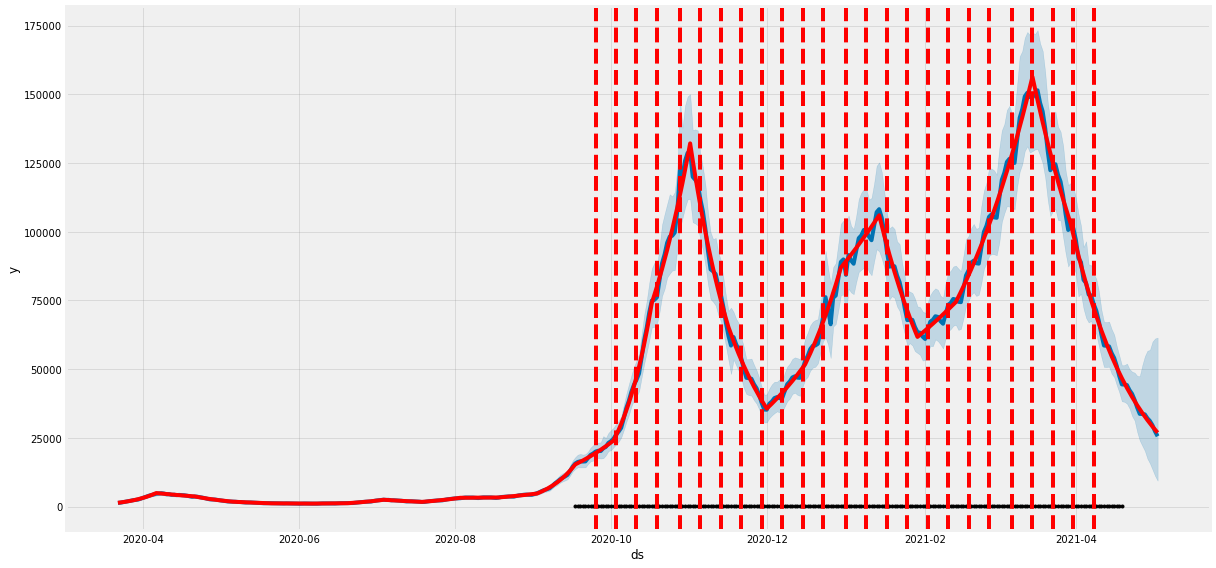

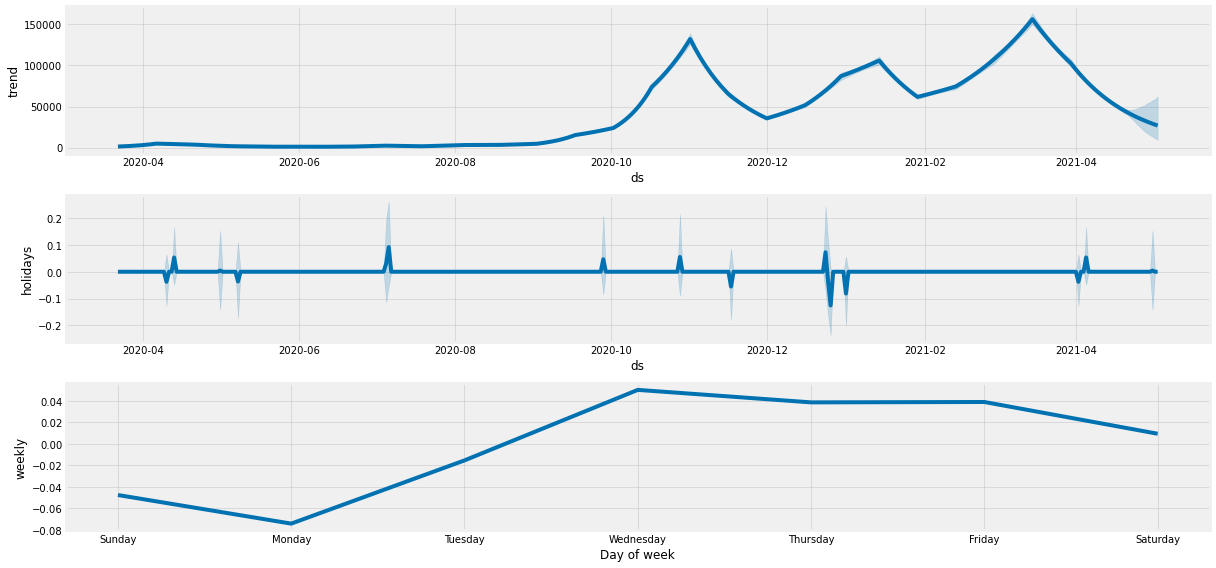

In [162]:
print('MAPE on test data: {m:.3f}%'.format(m=mape(active["y"][-14:], best_forecast_a_inversed["yhat"][-14:])))
# Plot summary graphs
fig = best_model_a.plot(forecast_a_inversed, figsize=figsize)
a = add_changepoints_to_plot(fig.gca(),best_model_a, forecast_a_inversed)
fig = best_model_a.plot_components(forecast_a_inversed, figsize=figsize)

MAPE on test data: 7.993%


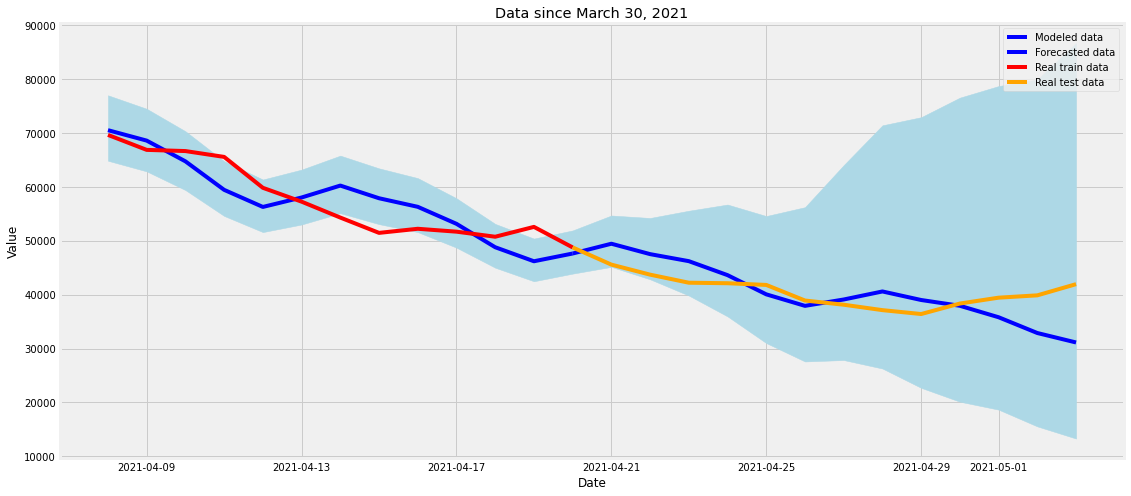

In [199]:
plot_forecast_slice(active[179:], best_forecast_a_inversed, 203, forecast_horizon=14, title='Data since March 30, 2021', plt_save_path='../figures/forecast_active_b_fc.png')

#### Best changepoint selection CURED

After training first model, i decided to select changepoint, training on data from which will give us the loweet MAPE error on test data

In [174]:
changepoints_i_i = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

models_c, mapes_c = prophet_best_slice(cured, changepoints_i_i, predict_depth=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,  
                                      changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, holidays_prior_scale=10.0, 
                                      seasonality_mode='additive', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=0)

From changepoint = 0 info:
MAPE train: 36.96522891002121, MAPE test: 2.170371767005036
From changepoint = 15 info:
MAPE train: 5.004747758801801, MAPE test: 1.9125940680981468
From changepoint = 30 info:
MAPE train: 3.158966771733685, MAPE test: 1.901731066107562
From changepoint = 45 info:
MAPE train: 2.855665712520465, MAPE test: 1.6568048063172451
From changepoint = 60 info:
MAPE train: 2.364711598033934, MAPE test: 1.408006970190595
From changepoint = 75 info:
MAPE train: 2.2711216916944954, MAPE test: 1.3050180442839436
From changepoint = 90 info:
MAPE train: 1.8546340794242178, MAPE test: 1.3636706368403892
From changepoint = 104 info:
MAPE train: 1.6104288012592387, MAPE test: 1.2854079256997497
From changepoint = 119 info:
MAPE train: 1.5307535999992223, MAPE test: 1.192053327625491
From changepoint = 134 info:
MAPE train: 1.2676161186572545, MAPE test: 1.0917218906009012
From changepoint = 149 info:
MAPE train: 1.0623207570354334, MAPE test: 1.0690507697919422
From changepoint

#### The best changepoint is with index = 283 and gives MAPE = 0.290%

Min MAPE: 0.29152214449583225


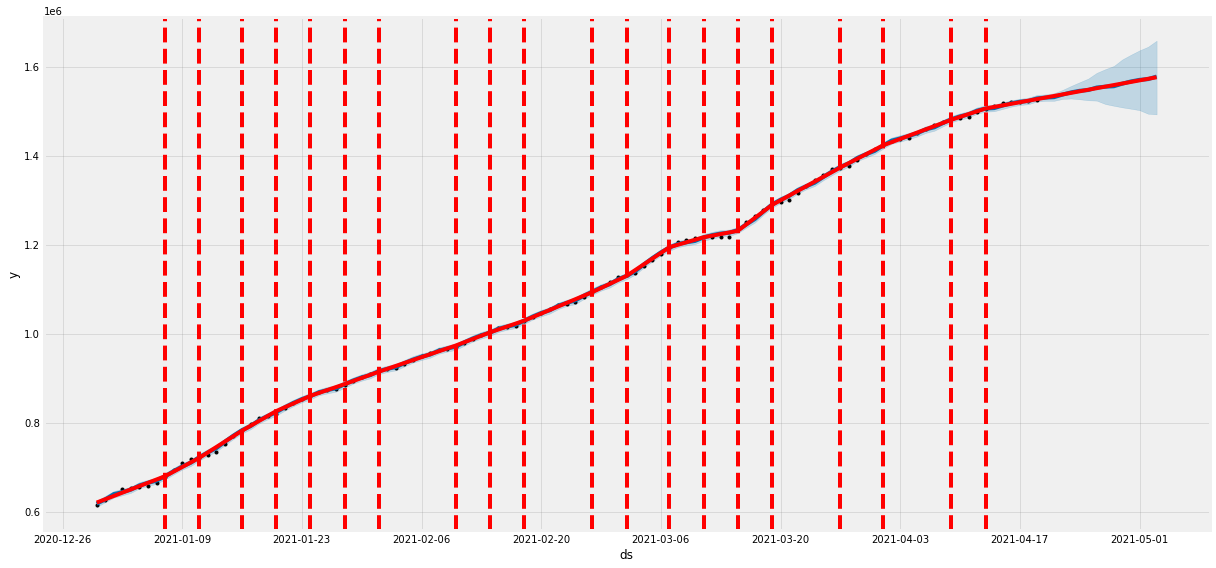

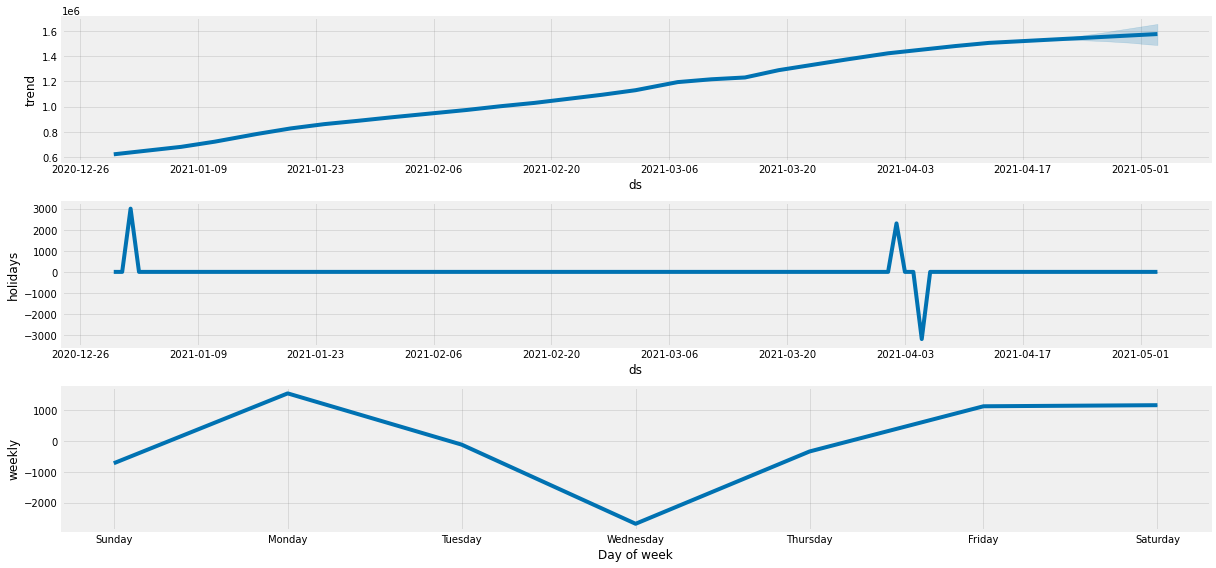

In [175]:
print(f'Min MAPE: {min(mapes_c)}')
best_model_c, best_forecast_c = models_c[np.argmin(mapes_c)]
# Plot summary graphs
fig = best_model_c.plot(best_forecast_c, figsize=figsize)
a = add_changepoints_to_plot(fig.gca(), best_model_c, best_forecast_c)
fig = best_model_c.plot_components(best_forecast_c, figsize=figsize)

MAPE on test data: 0.292%


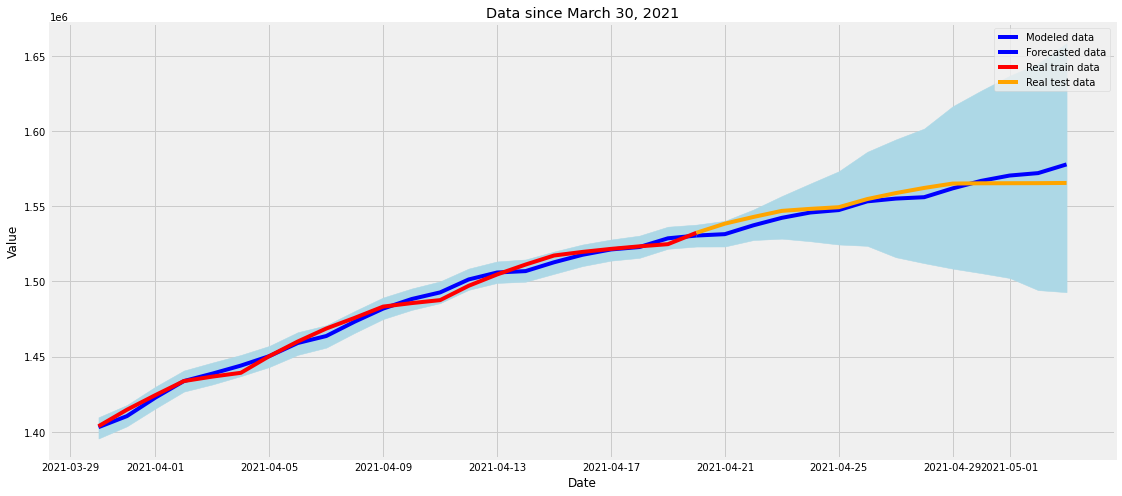

In [200]:
plot_forecast_slice(cured[283:], best_forecast_c, -35, forecast_horizon=14, title='Data since March 30, 2021', plt_save_path='../figures/forecast_cured_b_fc.png')

#### Best changepoint selection DEAD

After training first model, i decided to select changepoint, training on data from which will give us the loweet MAPE error on test data

In [178]:
changepoints_i_i = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

models_d, mapes_d = prophet_best_slice(dead, changepoints_i_i, predict_depth=14, growth='linear', holidays=None, c_holidays='CZ',
                                      daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,  
                                      changepoint_prior_scale=1.0, seasonality_prior_scale=1.0, holidays_prior_scale=10.0, 
                                      seasonality_mode='additive', 
                                      changepoint_range=0.95, interval_width=0.95, mcmc_samples=0)

From changepoint = 0 info:
MAPE train: 8.298367682041546, MAPE test: 1.7199050019547233
From changepoint = 15 info:
MAPE train: 0.7858974130914528, MAPE test: 1.6239835393605302
From changepoint = 30 info:
MAPE train: 0.5648328718129291, MAPE test: 1.6184248083783639
From changepoint = 45 info:
MAPE train: 0.5373549607141374, MAPE test: 1.5191254588238687
From changepoint = 60 info:
MAPE train: 0.4649403437516497, MAPE test: 1.3882328040259142
From changepoint = 75 info:
MAPE train: 0.42150670396065504, MAPE test: 1.319644335790322
From changepoint = 90 info:
MAPE train: 0.44564871685810764, MAPE test: 1.3355422213775363
From changepoint = 104 info:
MAPE train: 0.4701597558451788, MAPE test: 1.2328791600369062
From changepoint = 119 info:
MAPE train: 0.42009132739151783, MAPE test: 1.1246642023956206
From changepoint = 134 info:
MAPE train: 0.3671322076461632, MAPE test: 1.0517230662180321
From changepoint = 149 info:
MAPE train: 0.3425106128821953, MAPE test: 1.0571733093182947
From c

#### The best changepoint is with index = 328 and gives MAPE = 0.435%

Min MAPE: 0.4350055814657097


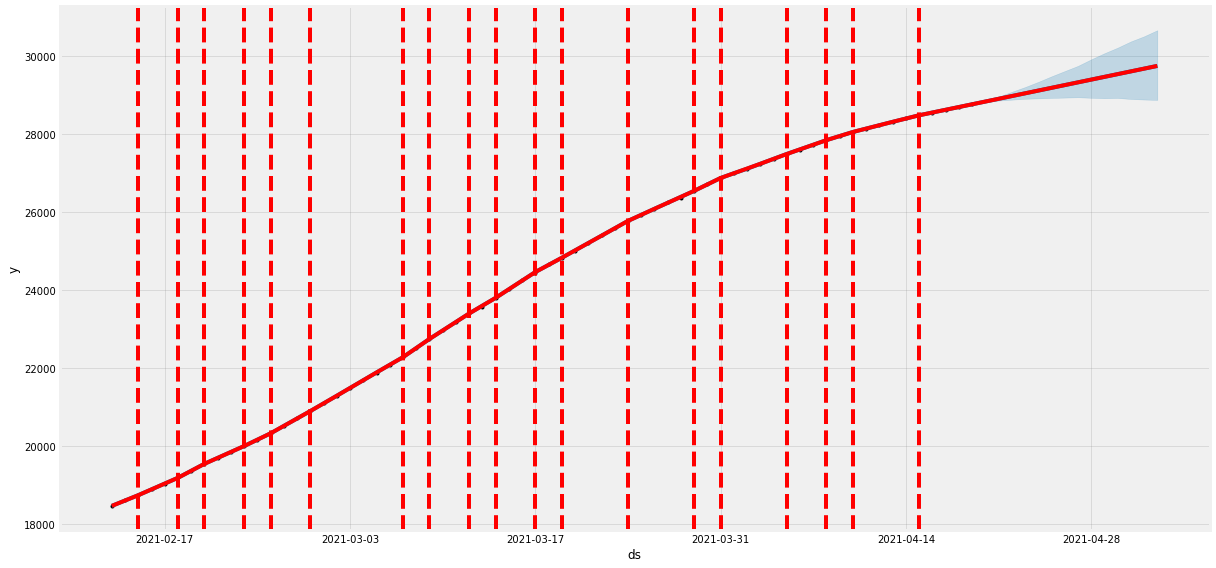

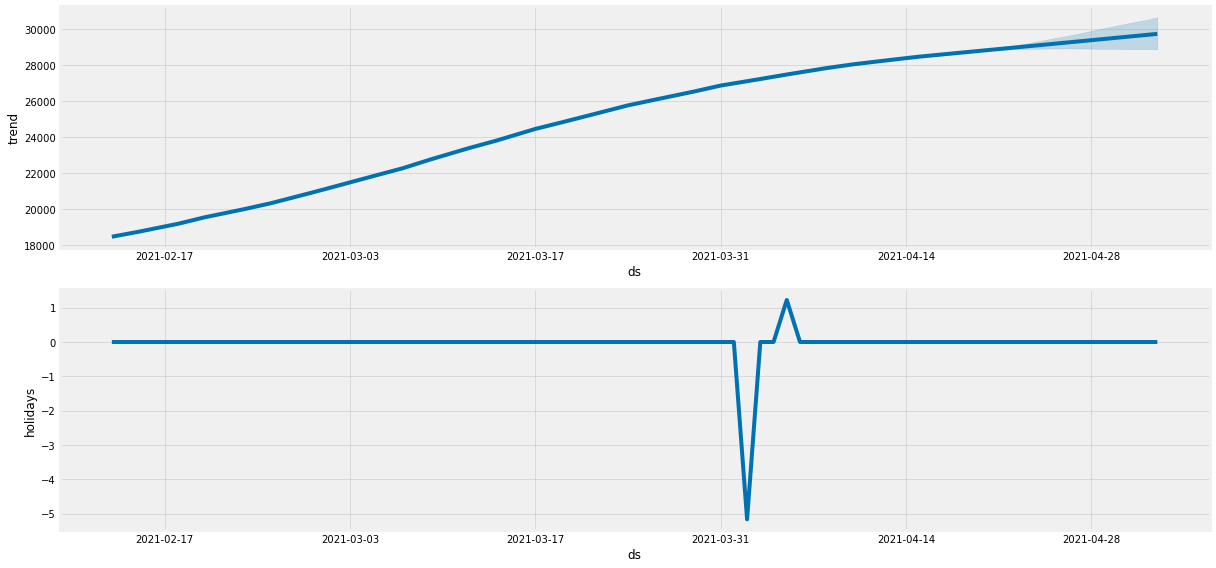

In [179]:
print(f'Min MAPE: {min(mapes_d)}')
best_model_d, best_forecast_d = models_d[np.argmin(mapes_d)]
# Plot summary graphs
fig = best_model_d.plot(best_forecast_d, figsize=figsize)
a = add_changepoints_to_plot(fig.gca(), best_model_d, best_forecast_d)
fig = best_model_d.plot_components(best_forecast_d, figsize=figsize)

MAPE on test data: 0.435%


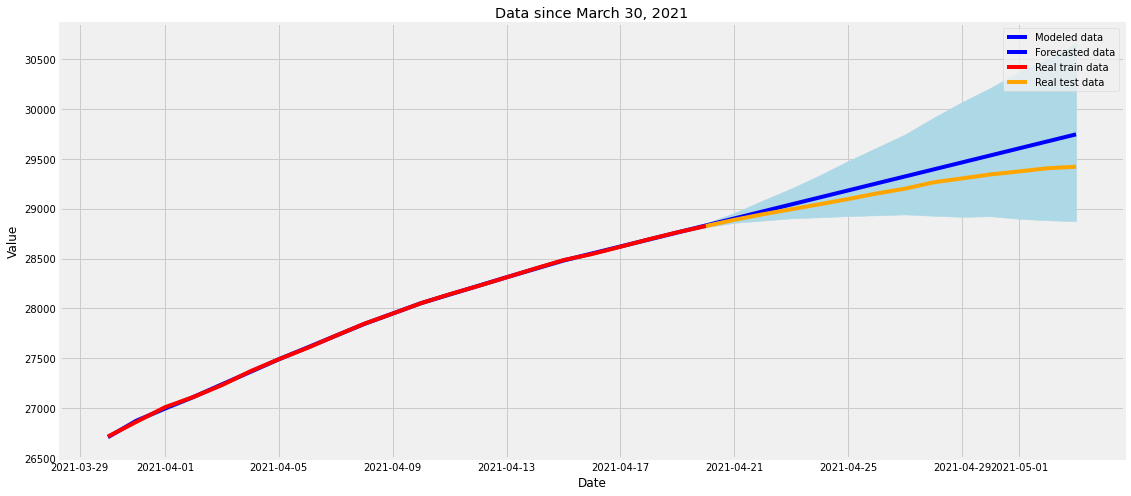

In [201]:
plot_forecast_slice(dead[328:], best_forecast_d, -35, forecast_horizon=14, title='Data since March 30, 2021', plt_save_path='../figures/forecast_dead_b_fc.png')

### Best model residual analysis

In [394]:
def resid_dagnostics(residuals, figsize=(15, 6), savepath='../figures/', lags=10):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    std_resid_ax = plt.subplot2grid(layout, (0, 0))
    correlogram_ax = plt.subplot2grid(layout, (1, 1))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    qq_ax = plt.subplot2grid(layout, (1, 0))
    
    residuals_std = (residuals - np.mean(residuals)) / np.std(residuals)
    residuals_std.plot(ax=std_resid_ax)
    std_resid_ax.set_title('Standartized residuals for "y"')
    
    plot_acf(residuals, lags=lags, ax=correlogram_ax, alpha=0.5, title='Correlogram')
    
    residuals_std.hist(ax=hist_ax, density=True, legend=True)
    # Ddensity plot
    residuals_std.plot(ax=hist_ax, kind='kde', figsize=(15, 7), legend=True)
    
    h = [x for x in np.arange(-4.0, 4.0, 0.01)]
    pdf = norm.pdf(h, 0, 1)
    hist_ax.plot(h, pdf, label='N(0, 1)')
    
    L =hist_ax.legend()
    L.get_texts()[0].set_text('KDE')
    L.get_texts()[2].set_text('Hist')
#     L.get_texts()[2].set_text('N(0, 1)')
    
    hist_ax.set_title('Histogram plus estimated density')
    
    qqplot(residuals_std, ax=qq_ax, line='s')
    qq_ax.set_title('Normal Q-Q')
    plt.savefig(savepath)
    plt.show()
    
    # Tests
    results_lb = acorr_ljungbox(residuals, lags=[10], period=7, return_df=True)
    results_jb = jarque_bera(residuals)
#     resuts_het = het_white(residuals)
    
    print('LB test for lags 1-14:')
    display(results_lb)
    print(f'JB test: Statistics value {results_jb[0]}; P-value {results_jb[1]}')

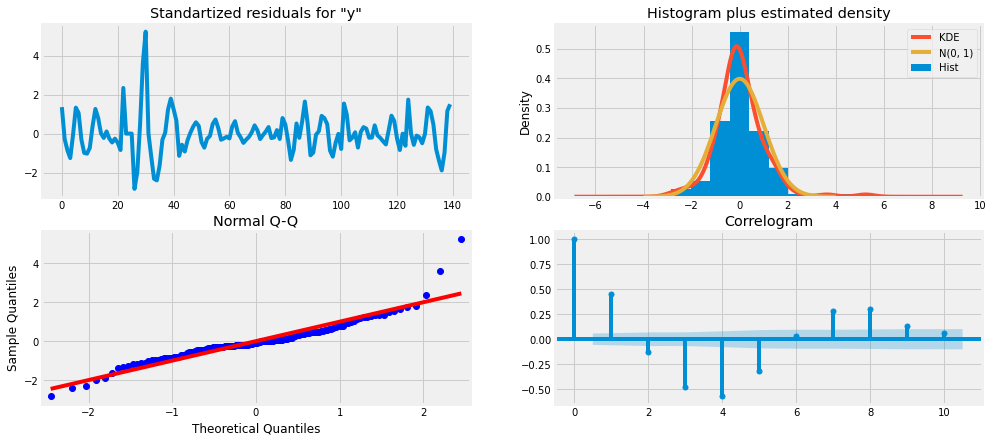

LB test for lags 1-14:


,lb_stat,lb_pvalue
1,29.696388,5.052889e-08
2,32.054639,1.095024e-07
3,65.846601,3.305602e-14
4,113.694152,1.185523e-23
5,128.223291,5.669648e-26
6,128.360845,2.845138e-25
7,139.883542,5.376704e-27
8,153.661785,3.375117e-29
9,156.376228,4.200549e-29
10,156.880585,1.426217e-28


JB test: Statistics value 215.5773885785525; P-value 1.5415757097025375e-47


In [395]:
data_resid_inf = pd.merge(infected[254:-14], best_forecast_i[['ds', 'yhat']][:-14], on='ds')
data_resid_inf['resid'] = data_resid_inf['y'] - data_resid_inf['yhat']
residuals_inf = data_resid_inf['resid']

resid_dagnostics(residuals_inf, figsize=(15, 6), savepath='../figures/resid_prophet_infected_cp.png')

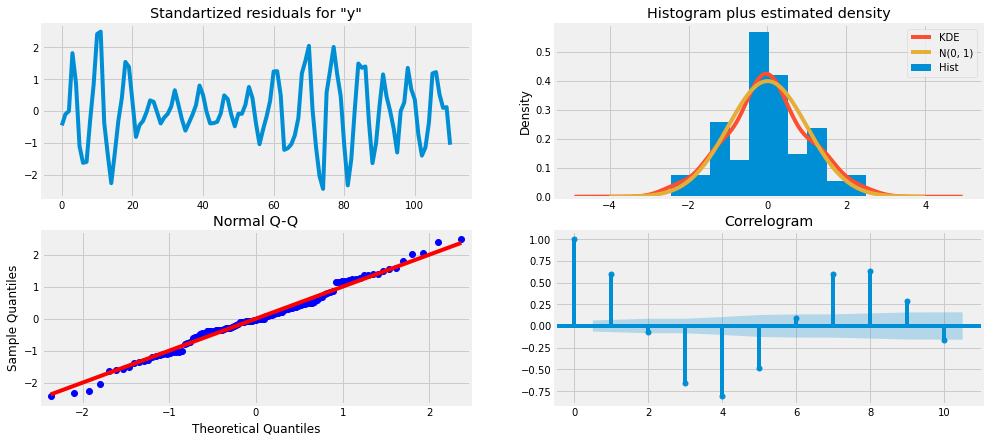

LB test for lags 1-14:


,lb_stat,lb_pvalue
1,40.509963,1.956161e-10
2,41.114970,1.180315e-09
3,91.582501,1.001442e-19
4,168.786350,1.905166e-35
5,196.132439,1.908318e-40
6,197.116275,7.796722e-40
7,241.214903,2.049882e-48
8,290.653501,4.011209e-58
9,301.222261,1.436862e-59
10,304.578729,1.673085e-59


JB test: Statistics value 0.02144869628845577; P-value 0.9893329526564877


In [396]:
data_resid_c = pd.merge(cured[283:-14], best_forecast_c[['ds', 'yhat']][:-14], on='ds')
data_resid_c['resid'] = data_resid_c['y'] - data_resid_c['yhat']
residuals_c = data_resid_c['resid']

resid_dagnostics(residuals_c, figsize=(15, 6), savepath='../figures/resid_prophet_cured_cp.png')

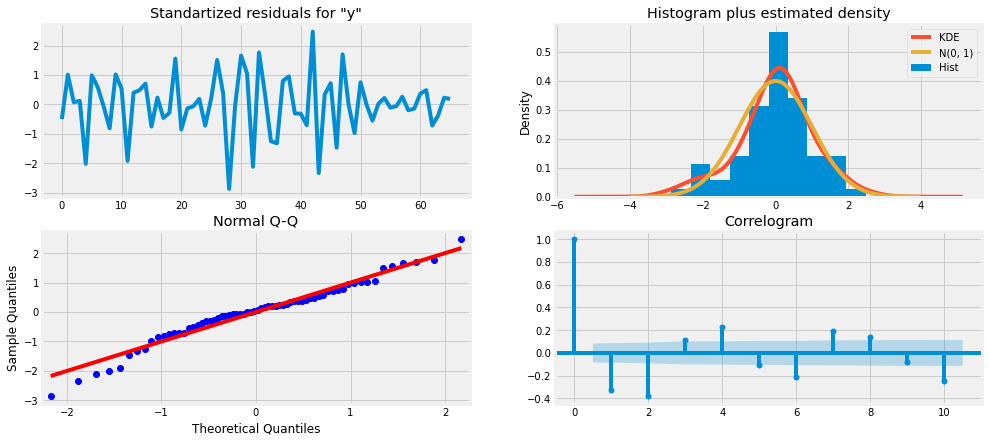

LB test for lags 1-14:


,lb_stat,lb_pvalue
1,7.241331,0.007124
2,17.502104,0.000158
3,18.361543,0.000370
4,22.107938,0.000191
5,22.874317,0.000357
6,26.216107,0.000203
7,29.100081,0.000139
8,30.549959,0.000169
9,31.043642,0.000291
10,35.926012,0.000087


JB test: Statistics value 3.0390191039920924; P-value 0.21881918006930834


In [397]:
data_resid_d = pd.merge(dead[328:-14], best_forecast_d[['ds', 'yhat']][:-14], on='ds')
data_resid_d['resid'] = data_resid_d['y'] - data_resid_d['yhat']
residuals_d = data_resid_d['resid']

resid_dagnostics(residuals_d, figsize=(15, 6), savepath='../figures/resid_prophet_dead_cp.png', lags=10)

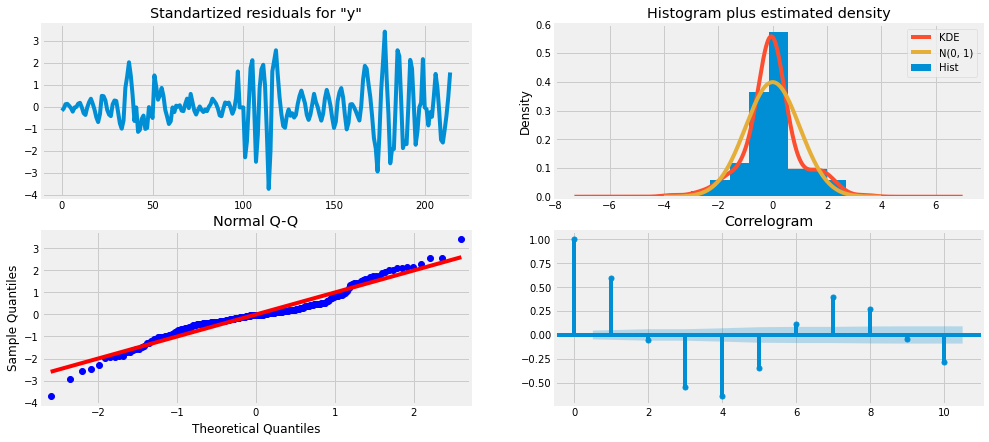

LB test for lags 1-14:


,lb_stat,lb_pvalue
1,76.976711,1.729858e-18
2,77.502651,1.480857e-17
3,142.363706,1.168888e-30
4,233.482106,2.349269e-49
5,260.022541,3.882924e-54
6,262.803886,7.510083e-54
7,298.201595,1.464751e-60
8,315.273946,2.302749e-63
9,315.698716,1.215557e-62
10,334.222593,8.846170e-66


JB test: Statistics value 23.794771307273756; P-value 6.80818050328028e-06


In [398]:
data_resid_a = pd.merge(active[179:-14], best_forecast_a_inversed[['ds', 'yhat']][:-14], on='ds')
data_resid_a['resid'] = data_resid_a['y'] - data_resid_a['yhat']
residuals_a = data_resid_a['resid']

resid_dagnostics(residuals_a, figsize=(15, 6), savepath='../figures/resid_prophet_active_cp.png')

## SARIMA modeling

Accoding to analysis at the beggining of the notebook. I decided to select SARIMA(1, 1, 0)x(1, 1, 1, 7) model.

In [55]:
sarima = sm.tsa.arima.ARIMA(infected['y'][:-14], 
                            order=(1, 1, 0), 
                            seasonal_order=(1, 1, 0, 7),
                            trend='n').fit()

print(sarima.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  394
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -3325.967
Date:                         Mon, 10 May 2021   AIC                           6657.934
Time:                                 13:26:53   BIC                           6669.802
Sample:                                      0   HQIC                          6662.640
                                         - 394                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7728      0.020     38.401      0.000       0.733       0.812
ar.S.L7       -0.2998      0.026    -11.700      0.000     

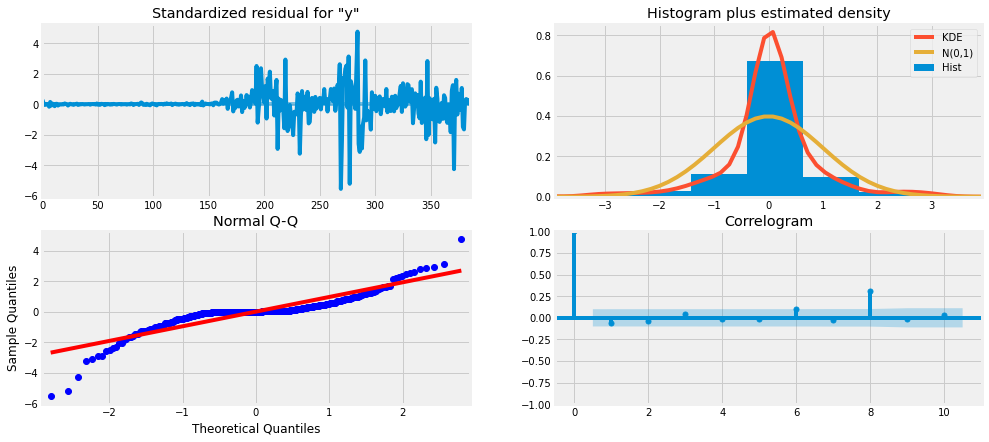

In [57]:
sarima.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_infected.png')
plt.show()

##### Prediction using SARIMA model

First of all, i've decided to predict using all historical data

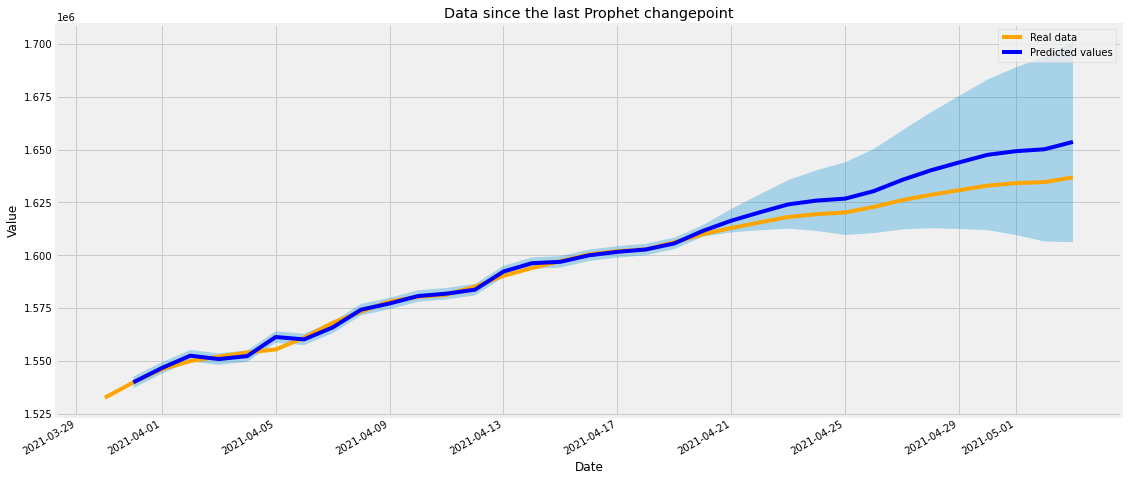

In [586]:
f_steps = 14

preds = sarima.get_prediction(start=1, end=len(infected[:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
# preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : inv_boxcox(x, lam_i_s))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(infected['ds'][373:], infected['y'][373:], label='Real data', color='orange')
preds_df['ds'] = infected['ds']
preds_df.set_index('ds')['mean'][373:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][373:], preds_df['mean_ci_lower'][373:], preds_df['mean_ci_upper'][373:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_infected.png')
plt.show()

In [587]:
y_train_pred = preds_df['mean'][:-14]
y_train = infected['y'][:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = infected['y'][-14:]

print(f'MAPE on train data = {mape(y_train[35:], y_train_pred[35:]): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')

MAPE on train data =  1.44 % 
MAPE on test data =  0.79 %


In [58]:
sarima = sm.tsa.arima.ARIMA(cured['y'][:-14], 
                            order=(1, 1, 0), 
                            seasonal_order=(1, 1, 0, 7),
                            trend='n').fit()

print(sarima.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  394
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -3470.984
Date:                         Mon, 10 May 2021   AIC                           6947.967
Time:                                 13:27:41   BIC                           6959.835
Sample:                                      0   HQIC                          6952.673
                                         - 394                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7032      0.020     35.473      0.000       0.664       0.742
ar.S.L7       -0.2506      0.037     -6.783      0.000     

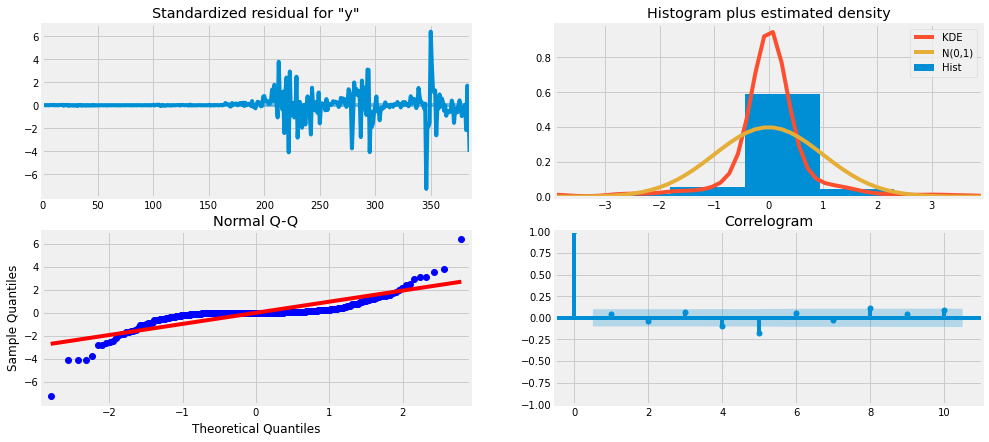

In [60]:
sarima.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_cured.png')
plt.show()

##### Prediction using SARIMA model

First of all, i've decided to predict using all historical data

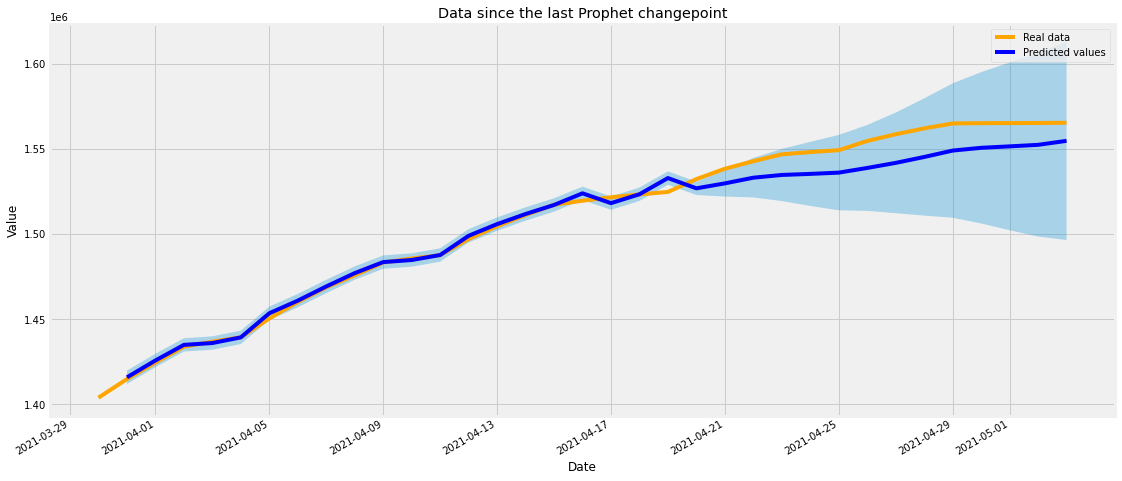

In [590]:
f_steps = 14

preds = sarima.get_prediction(start=1, end=len(cured[:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
# preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : inv_boxcox(x, lam_i_s))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(cured['ds'][373:], cured['y'][373:], label='Real data', color='orange')
preds_df['ds'] = cured['ds']
preds_df.set_index('ds')['mean'][373:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][373:], preds_df['mean_ci_lower'][373:], preds_df['mean_ci_upper'][373:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_cured.png')
plt.show()

In [591]:
y_train_pred = preds_df['mean'][:-14]
y_train = cured['y'][:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = cured['y'][-14:]

print(f'MAPE on train data = {mape(y_train[35:], y_train_pred[35:]): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')

MAPE on train data =  1.58 % 
MAPE on test data =  0.68 %


In [61]:
sarima = sm.tsa.arima.ARIMA(dead['y'][:-14], 
                            order=(0, 2, 1), 
                            seasonal_order=(0, 0, 0, 0),
                            trend='n').fit()

print(sarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  394
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1543.549
Date:                Mon, 10 May 2021   AIC                           3091.098
Time:                        13:28:02   BIC                           3099.040
Sample:                             0   HQIC                          3094.246
                                - 394                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4375      0.033    -13.202      0.000      -0.502      -0.373
sigma2       153.9811      7.074     21.767      0.000     140.116     167.846
Ljung-Box (L1) (Q):                   2.94   Jarque-

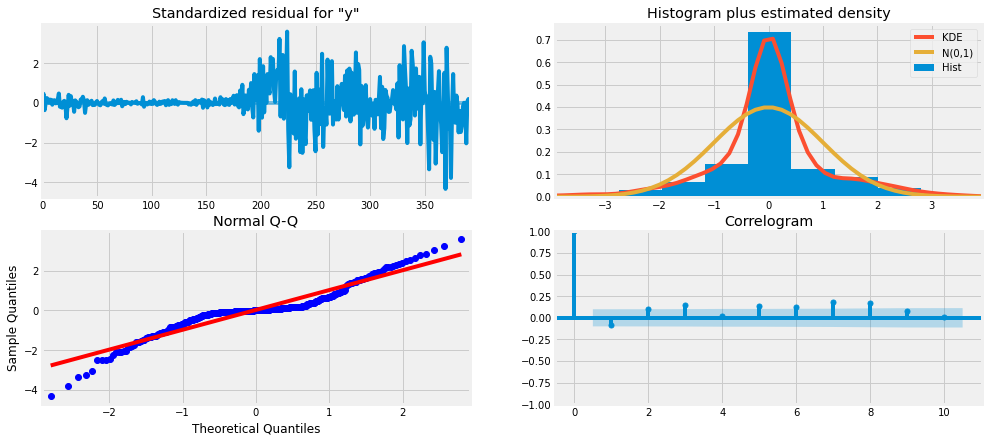

In [63]:
sarima.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_dead.png')
plt.show()

##### Prediction using SARIMA model

First of all, i've decided to predict using all historical data

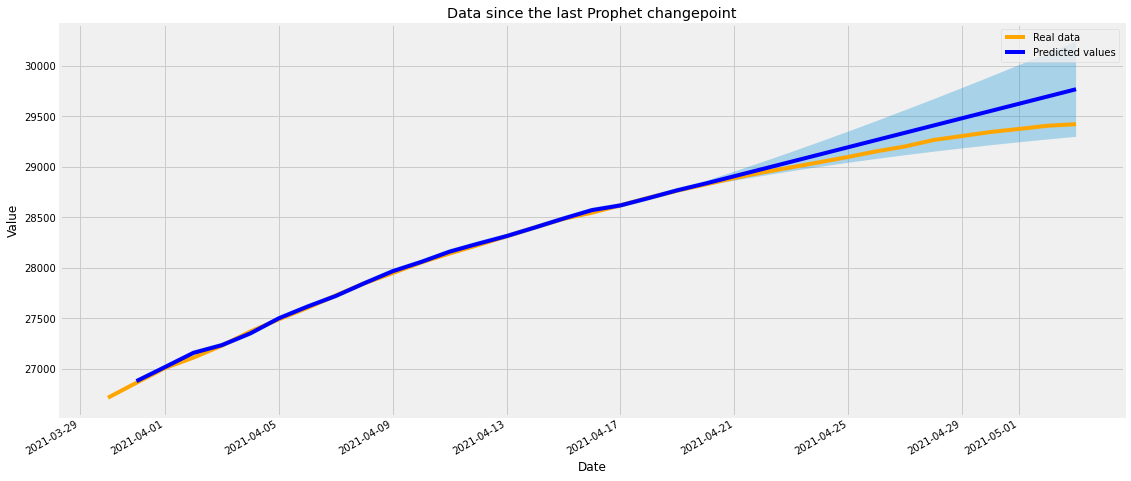

In [64]:
f_steps = 14

preds = sarima.get_prediction(start=1, end=len(dead[:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
# preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : inv_boxcox(x, lam_i_s))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(dead['ds'][373:], dead['y'][373:], label='Real data', color='orange')
preds_df['ds'] = dead['ds']
preds_df.set_index('ds')['mean'][373:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][373:], preds_df['mean_ci_lower'][373:], preds_df['mean_ci_upper'][373:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_dead.png')
plt.show()

In [65]:
y_train_pred = preds_df['mean'][:-14]
y_train = dead['y'][:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = dead['y'][-14:]

print(f'MAPE on train data = {mape(y_train[35:], y_train_pred[35:]): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')

MAPE on train data =  1.31 % 
MAPE on test data =  0.72 %


In [12]:
sarima = sm.tsa.arima.ARIMA(active_log['y'][:-14], 
                            order=(1, 1, 0), 
                            seasonal_order=(1, 1, 0, 7),
                            trend='n').fit()

print(sarima.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  394
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                 755.910
Date:                         Thu, 13 May 2021   AIC                          -1505.819
Time:                                 14:15:49   BIC                          -1493.952
Sample:                                      0   HQIC                         -1501.113
                                         - 394                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6672      0.034     19.723      0.000       0.601       0.734
ar.S.L7       -0.3276      0.039     -8.493      0.000     

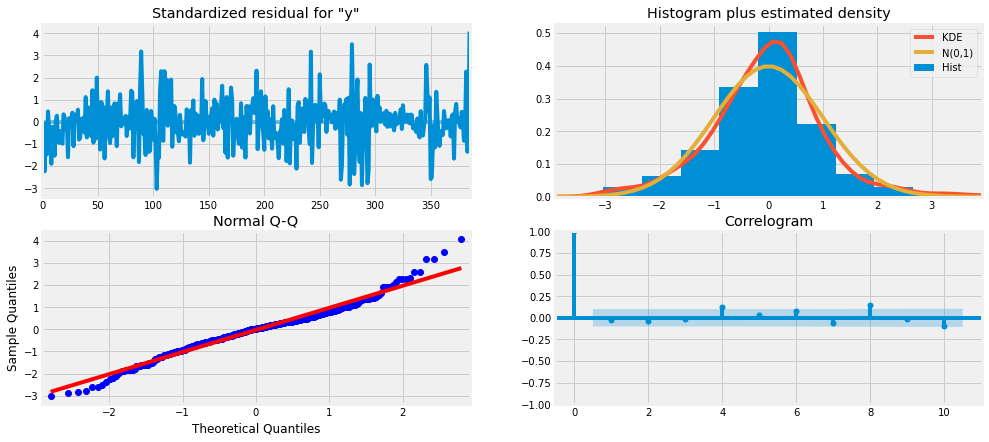

In [14]:
sarima.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_active.png')
plt.show()

##### Prediction using SARIMA model

First of all, i've decided to predict using all historical data

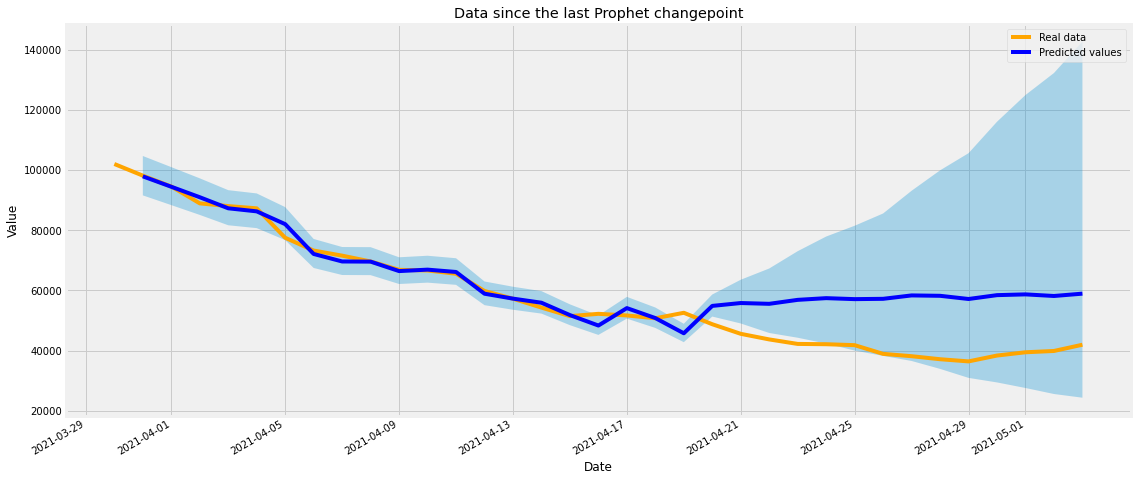

In [18]:
f_steps = 14

preds = sarima.get_prediction(start=1, end=len(active_log[:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : log_transform(x, inverse=True))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(active['ds'][373:], active['y'][373:], label='Real data', color='orange')
preds_df['ds'] = active['ds']
preds_df.set_index('ds')['mean'][373:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][373:], preds_df['mean_ci_lower'][373:], preds_df['mean_ci_upper'][373:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_active.png')
plt.show()

In [19]:
y_train_pred = preds_df['mean'][:-14]
y_train = active['y'][:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = active['y'][-14:]

print(f'MAPE on train data = {mape(y_train[35:], y_train_pred[35:]): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')

MAPE on train data =  4.71 % 
MAPE on test data =  41.76 %


### SARIMA model training using slices of historical data (part from specific trend changepoints detected using Prophet model)


In [612]:
changepoints = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

f_steps = 14

for changepoint in changepoints:

    sarima_cc = sm.tsa.arima.ARIMA(infected['y'][changepoint:-f_steps], 
                                order=(1, 1, 0), 
                                seasonal_order=(1, 1, 0, 7),
                                trend='n').fit()
    
    
    preds = sarima_cc.get_prediction(start=1, end=len(infected[changepoint:-14]) + f_steps, dynamic=False)
    preds_df = preds.summary_frame()
    
    y_train_pred = preds_df['mean'][:-f_steps]
    y_train = infected['y'][changepoint:-f_steps]
    
    y_test_pred = preds_df['mean'][-f_steps:]
    y_test = infected['y'][-f_steps:]
    
    print(f'\nChangepoint {changepoint}: MAPE on train data = {mape(y_train, y_train_pred): .3f} %; MAPE on test data = {mape(y_test, y_test_pred): .3f}%')


Changepoint 0: MAPE on train data =  1.924 %; MAPE on test data =  0.790%

Changepoint 15: MAPE on train data =  1.881 %; MAPE on test data =  0.786%

Changepoint 30: MAPE on train data =  1.971 %; MAPE on test data =  0.781%

Changepoint 45: MAPE on train data =  2.046 %; MAPE on test data =  0.778%

Changepoint 60: MAPE on train data =  2.111 %; MAPE on test data =  0.775%

Changepoint 75: MAPE on train data =  2.187 %; MAPE on test data =  0.773%

Changepoint 90: MAPE on train data =  2.235 %; MAPE on test data =  0.769%

Changepoint 104: MAPE on train data =  2.307 %; MAPE on test data =  0.759%

Changepoint 119: MAPE on train data =  2.340 %; MAPE on test data =  0.750%

Changepoint 134: MAPE on train data =  2.391 %; MAPE on test data =  0.733%

Changepoint 149: MAPE on train data =  2.426 %; MAPE on test data =  0.711%

Changepoint 164: MAPE on train data =  2.326 %; MAPE on test data =  0.672%

Changepoint 179: MAPE on train data =  2.019 %; MAPE on test data =  0.561%

Change

##### Model training from the best changepoint
According to this summary we got improvement of AIC and BIC from 6700 to 3500

In [69]:
changepoint = 194

sarima_ccc = sm.tsa.arima.ARIMA(infected['y'][changepoint:-14], 
                            order=(1, 1, 0), 
                            seasonal_order=(1, 1, 0, 7),
                            trend='n').fit()

print(sarima_ccc.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  200
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -1772.443
Date:                         Mon, 10 May 2021   AIC                           3550.886
Time:                                 13:37:02   BIC                           3560.659
Sample:                                      0   HQIC                          3554.844
                                         - 200                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1955      0.009     20.829      0.000       0.177       0.214
ar.S.L7        0.0158      0.037      0.431      0.667     

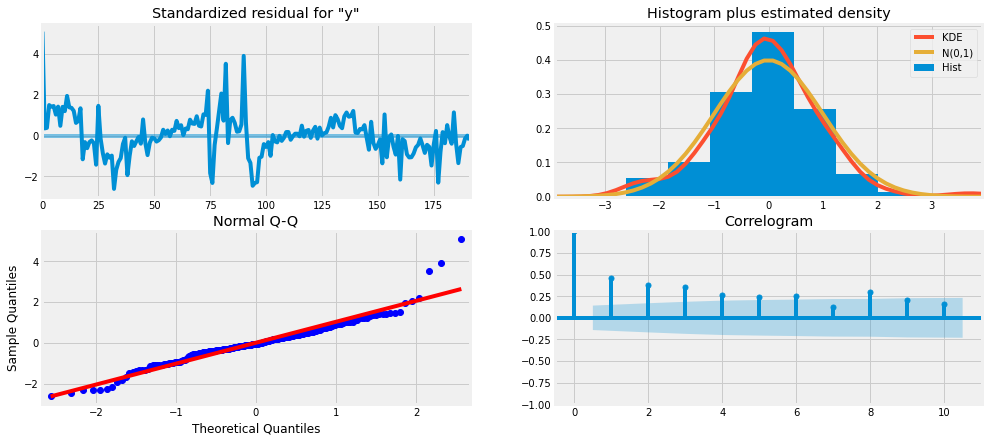

In [70]:
sarima_ccc.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_infected_cp.png')
plt.show()

##### Final SARIMA forecast 

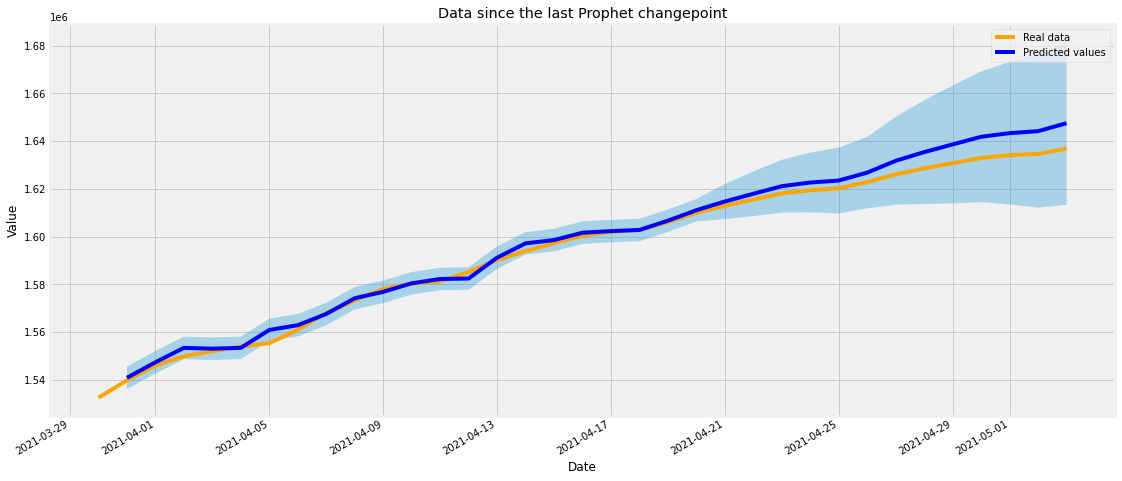

MAPE on train data =  1.74 % 
MAPE on test data =  0.52 %


In [22]:
f_steps = 14

preds = sarima_ccc.get_prediction(start=1, end=len(infected[changepoint:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
# preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : inv_boxcox(x, lam_a_s))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(infected['ds'][-35:], infected['y'][-35:], label='Real data', color='orange')
preds_df['ds'] = infected['ds']
preds_df.set_index('ds')['mean'][-35:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][-35:], preds_df['mean_ci_lower'][-35:], preds_df['mean_ci_upper'][-35:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_infected_cp.png')
plt.show()

y_train_pred = preds_df['mean'][:-14]
y_train = infected['y'][changepoint:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = infected['y'][-14:]

print(f'MAPE on train data = {mape(y_train, y_train_pred): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')

In [624]:
changepoints = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

f_steps = 14

for changepoint in changepoints:

    sarima_cc = sm.tsa.arima.ARIMA(cured['y'][changepoint:-f_steps], 
                                order=(1, 1, 0), 
                                seasonal_order=(1, 1, 0, 7),
                                trend='n').fit()
    
    
    preds = sarima_cc.get_prediction(start=1, end=len(cured[changepoint:-14]) + f_steps, dynamic=False)
    preds_df = preds.summary_frame()
    
    y_train_pred = preds_df['mean'][:-f_steps]
    y_train = infected['y'][changepoint:-f_steps]
    
    y_test_pred = preds_df['mean'][-f_steps:]
    y_test = infected['y'][-f_steps:]
    
    print(f'\nChangepoint {changepoint}: MAPE on train data = {mape(y_train, y_train_pred): .3f} %; MAPE on test data = {mape(y_test, y_test_pred): .3f}%')


Changepoint 0: MAPE on train data =  22.540 %; MAPE on test data =  4.972%

Changepoint 15: MAPE on train data =  19.637 %; MAPE on test data =  4.972%

Changepoint 30: MAPE on train data =  17.412 %; MAPE on test data =  4.969%

Changepoint 45: MAPE on train data =  16.818 %; MAPE on test data =  4.958%

Changepoint 60: MAPE on train data =  16.829 %; MAPE on test data =  4.948%

Changepoint 75: MAPE on train data =  16.952 %; MAPE on test data =  4.941%

Changepoint 90: MAPE on train data =  17.062 %; MAPE on test data =  4.935%

Changepoint 104: MAPE on train data =  16.933 %; MAPE on test data =  4.927%

Changepoint 119: MAPE on train data =  17.013 %; MAPE on test data =  4.903%

Changepoint 134: MAPE on train data =  16.926 %; MAPE on test data =  4.885%

Changepoint 149: MAPE on train data =  16.893 %; MAPE on test data =  4.840%

Changepoint 164: MAPE on train data =  16.684 %; MAPE on test data =  4.777%

Changepoint 179: MAPE on train data =  15.704 %; MAPE on test data =  4

##### Model training from the best changepoint
According to this summary we got improvement of AIC and BIC from 6700 to 3500

In [71]:
changepoint = 283

sarima_ccc = sm.tsa.arima.ARIMA(cured['y'][changepoint:-14], 
                            order=(1, 1, 0), 
                            seasonal_order=(1, 1, 0, 7),
                            trend='n').fit()

print(sarima_ccc.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  111
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -1028.237
Date:                         Mon, 10 May 2021   AIC                           2062.474
Time:                                 13:37:23   BIC                           2070.378
Sample:                                      0   HQIC                          2065.675
                                         - 111                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0014      0.007     -0.210      0.834      -0.014       0.011
ar.S.L7       -0.0044      0.018     -0.241      0.810     

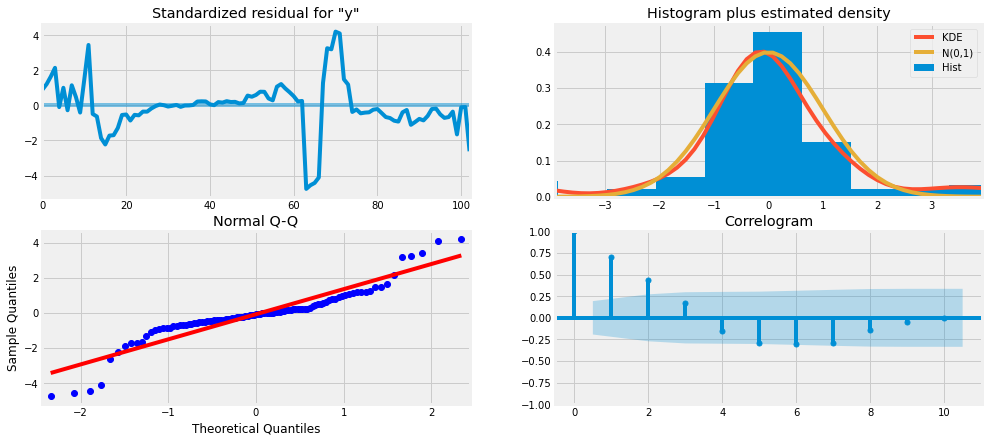

In [72]:
sarima_ccc.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_cured_cp.png')
plt.show()

##### Final SARIMA forecast 

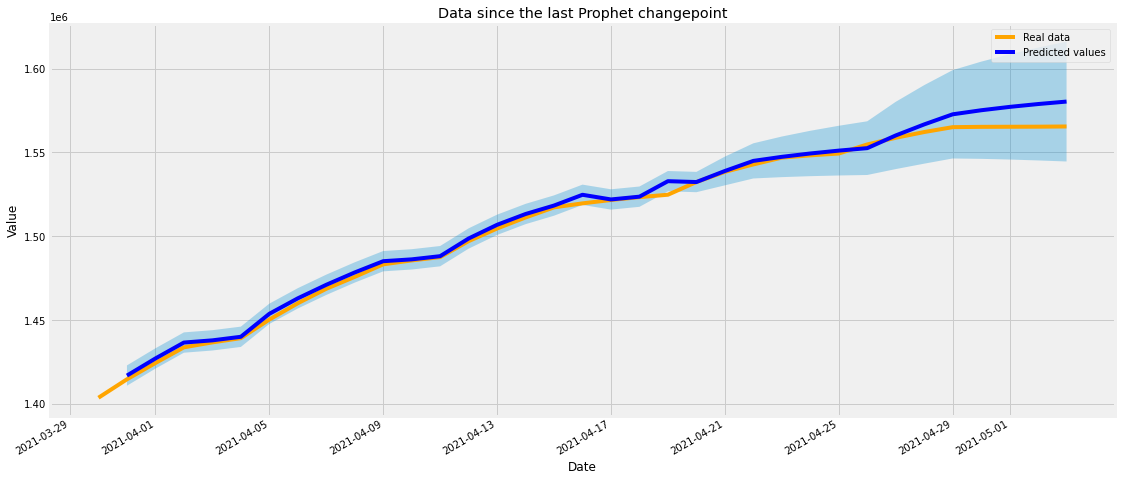

MAPE on train data =  9.59 % 
MAPE on test data =  3.78 %


In [27]:
f_steps = 14

preds = sarima_ccc.get_prediction(start=1, end=len(cured[changepoint:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
# preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : inv_boxcox(x, lam_a_s))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(cured['ds'][-35:], cured['y'][-35:], label='Real data', color='orange')
preds_df['ds'] = cured['ds']
preds_df.set_index('ds')['mean'][-35:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][-35:], preds_df['mean_ci_lower'][-35:], preds_df['mean_ci_upper'][-35:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_cured_cp.png')
plt.show()

y_train_pred = preds_df['mean'][:-14]
y_train = infected['y'][changepoint:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = infected['y'][-14:]

print(f'MAPE on train data = {mape(y_train, y_train_pred): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')

In [30]:
changepoints = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

f_steps = 14

for changepoint in changepoints:

    sarima_cc = sm.tsa.arima.ARIMA(dead['y'][changepoint:-f_steps], 
                                order=(0, 2, 1), 
                                seasonal_order=(0, 0, 0, 0),
                                trend='n').fit()
    
    
    preds = sarima_cc.get_prediction(start=1, end=len(dead[changepoint:-14]) + f_steps, dynamic=False)
    preds_df = preds.summary_frame()
    
    y_train_pred = preds_df['mean'][:-f_steps]
    y_train = dead['y'][changepoint:-f_steps]
    
    y_test_pred = preds_df['mean'][-f_steps:]
    y_test = dead['y'][-f_steps:]
    
    print(f'\nChangepoint {changepoint}: MAPE on train data = {mape(y_train, y_train_pred): .3f} %; MAPE on test data = {mape(y_test, y_test_pred): .3f}%')


Changepoint 0: MAPE on train data =  2.272 %; MAPE on test data =  0.722%

Changepoint 15: MAPE on train data =  1.630 %; MAPE on test data =  0.722%

Changepoint 30: MAPE on train data =  1.448 %; MAPE on test data =  0.722%

Changepoint 45: MAPE on train data =  1.438 %; MAPE on test data =  0.722%

Changepoint 60: MAPE on train data =  1.454 %; MAPE on test data =  0.722%

Changepoint 75: MAPE on train data =  1.506 %; MAPE on test data =  0.722%

Changepoint 90: MAPE on train data =  1.568 %; MAPE on test data =  0.722%

Changepoint 104: MAPE on train data =  1.633 %; MAPE on test data =  0.722%

Changepoint 119: MAPE on train data =  1.709 %; MAPE on test data =  0.722%

Changepoint 134: MAPE on train data =  1.782 %; MAPE on test data =  0.722%

Changepoint 149: MAPE on train data =  1.873 %; MAPE on test data =  0.722%

Changepoint 164: MAPE on train data =  1.973 %; MAPE on test data =  0.722%

Changepoint 179: MAPE on train data =  2.042 %; MAPE on test data =  0.722%

Change

##### Model training from the best changepoint
According to this summary we got improvement of AIC and BIC from 6700 to 3500

In [73]:
changepoint = 194

sarima_ccc = sm.tsa.arima.ARIMA(dead['y'][changepoint:-14], 
                            order=(0, 2, 1), 
                            seasonal_order=(0, 0, 0, 0),
                            trend='n').fit()

print(sarima_ccc.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -845.368
Date:                Mon, 10 May 2021   AIC                           1694.736
Time:                        13:37:39   BIC                           1701.312
Sample:                             0   HQIC                          1697.398
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4345      0.065     -6.712      0.000      -0.561      -0.308
sigma2       299.3458     29.640     10.099      0.000     241.252     357.439
Ljung-Box (L1) (Q):                   1.42   Jarque-

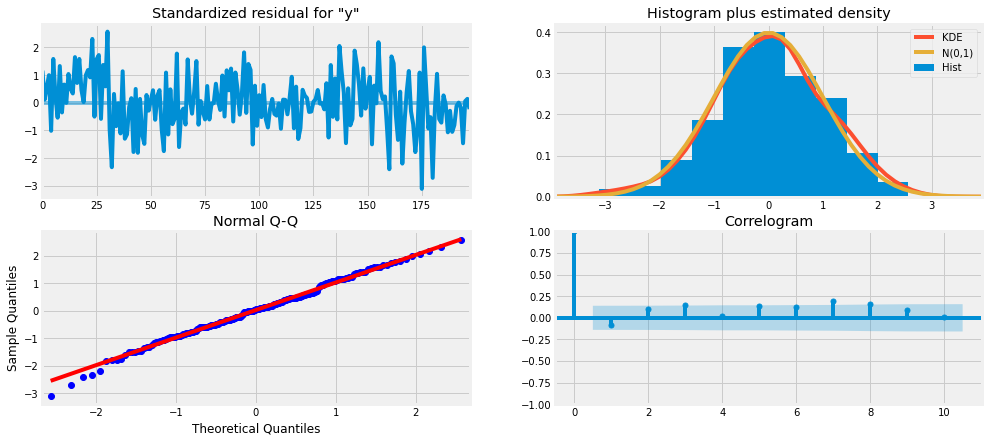

In [74]:
sarima_ccc.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_dead_cp.png')
plt.show()

##### Final SARIMA forecast 

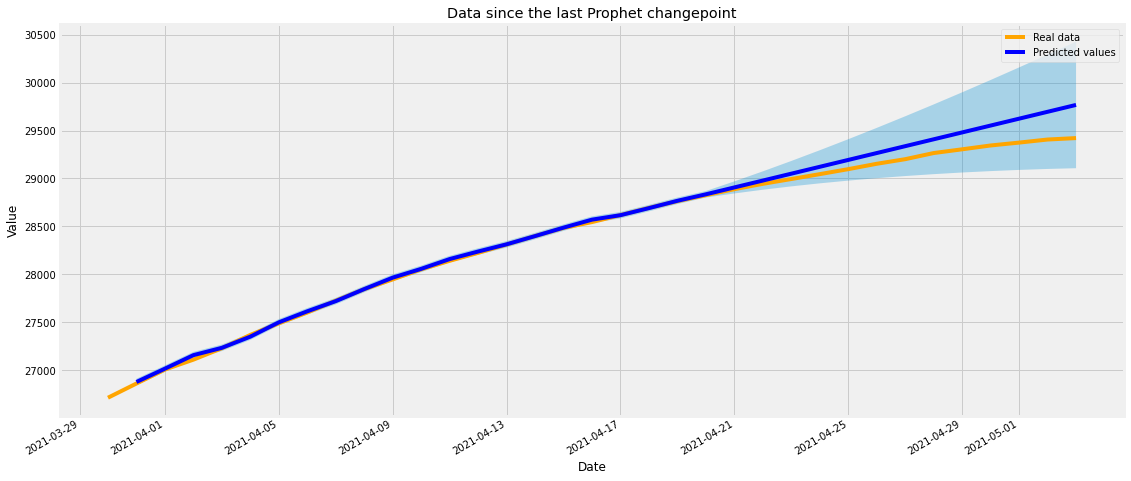

MAPE on train data =  2.02 % 
MAPE on test data =  0.72 %


In [33]:
f_steps = 14

preds = sarima_ccc.get_prediction(start=1, end=len(dead[changepoint:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
# preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : inv_boxcox(x, lam_a_s))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(dead['ds'][-35:], dead['y'][-35:], label='Real data', color='orange')
preds_df['ds'] = dead['ds']
preds_df.set_index('ds')['mean'][-35:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][-35:], preds_df['mean_ci_lower'][-35:], preds_df['mean_ci_upper'][-35:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_dead_cp.png')
plt.show()

y_train_pred = preds_df['mean'][:-14]
y_train = dead['y'][changepoint:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = dead['y'][-14:]

print(f'MAPE on train data = {mape(y_train, y_train_pred): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')

In [35]:
active_box = active.copy()
active_box['y'] = log_transform(active_box['y'], inverse=False)

In [36]:
changepoints = [0, 15,  30,  45,  60,  75,  90, 104, 119, 134, 149, 164, 179, 194,
            209, 224, 239, 254, 269, 283, 298, 313, 328, 343, 358, 373]

f_steps = 14

for changepoint in changepoints:

    sarima_cc = sm.tsa.arima.ARIMA(active_box['y'][changepoint:-f_steps], 
                                order=(1, 1, 0), 
                                seasonal_order=(1, 1, 0, 7),
                                trend='n').fit()
    
    
    preds = sarima_cc.get_prediction(start=1, end=len(active_box[changepoint:-14]) + f_steps, dynamic=False)
    preds_df = preds.summary_frame()
    
    y_train_pred = preds_df['mean'][:-f_steps]
    y_train = active_box['y'][changepoint:-f_steps]
    
    y_test_pred = preds_df['mean'][-f_steps:]
    y_test = active_box['y'][-f_steps:]
    
    print(f'\nChangepoint {changepoint}: MAPE on train data = {mape(y_train, y_train_pred): .3f} %; MAPE on test data = {mape(y_test, y_test_pred): .3f}%')


Changepoint 0: MAPE on train data =  0.580 %; MAPE on test data =  3.253%

Changepoint 15: MAPE on train data =  0.584 %; MAPE on test data =  2.971%

Changepoint 30: MAPE on train data =  0.599 %; MAPE on test data =  2.921%

Changepoint 45: MAPE on train data =  0.601 %; MAPE on test data =  2.936%

Changepoint 60: MAPE on train data =  0.610 %; MAPE on test data =  3.077%

Changepoint 75: MAPE on train data =  0.623 %; MAPE on test data =  3.108%

Changepoint 90: MAPE on train data =  0.637 %; MAPE on test data =  3.179%

Changepoint 104: MAPE on train data =  0.643 %; MAPE on test data =  2.913%

Changepoint 119: MAPE on train data =  0.645 %; MAPE on test data =  2.658%

Changepoint 134: MAPE on train data =  0.669 %; MAPE on test data =  2.648%

Changepoint 149: MAPE on train data =  0.692 %; MAPE on test data =  2.745%

Changepoint 164: MAPE on train data =  0.699 %; MAPE on test data =  2.695%

Changepoint 179: MAPE on train data =  0.700 %; MAPE on test data =  2.733%

Change

##### Model training from the best changepoint
According to this summary we got improvement of AIC and BIC from 6700 to 3500

In [75]:
changepoint = 358

sarima_ccc = sm.tsa.arima.ARIMA(active_box['y'][changepoint:-14], 
                            order=(1, 1, 0), 
                            seasonal_order=(1, 1, 0, 7),
                            trend='n').fit()

print(sarima_ccc.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                   36
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                  57.856
Date:                         Mon, 10 May 2021   AIC                           -109.711
Time:                                 13:38:23   BIC                           -105.714
Sample:                                      0   HQIC                          -108.489
                                          - 36                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0367      0.418      0.088      0.930      -0.782       0.855
ar.S.L7        0.2622      0.365      0.719      0.472     

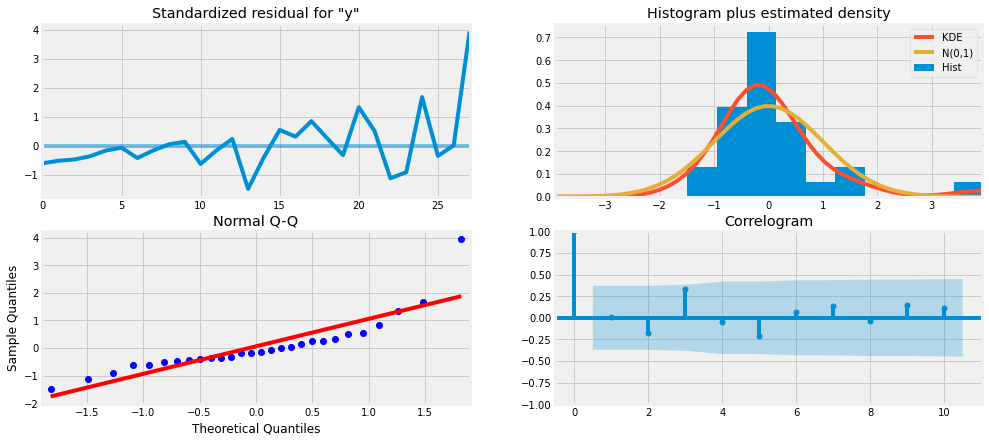

In [77]:
sarima_ccc.plot_diagnostics(figsize=(15, 7))
plt.savefig('../figures/residual_sarima_active_cp.png')
plt.show()

##### Final SARIMA forecast 

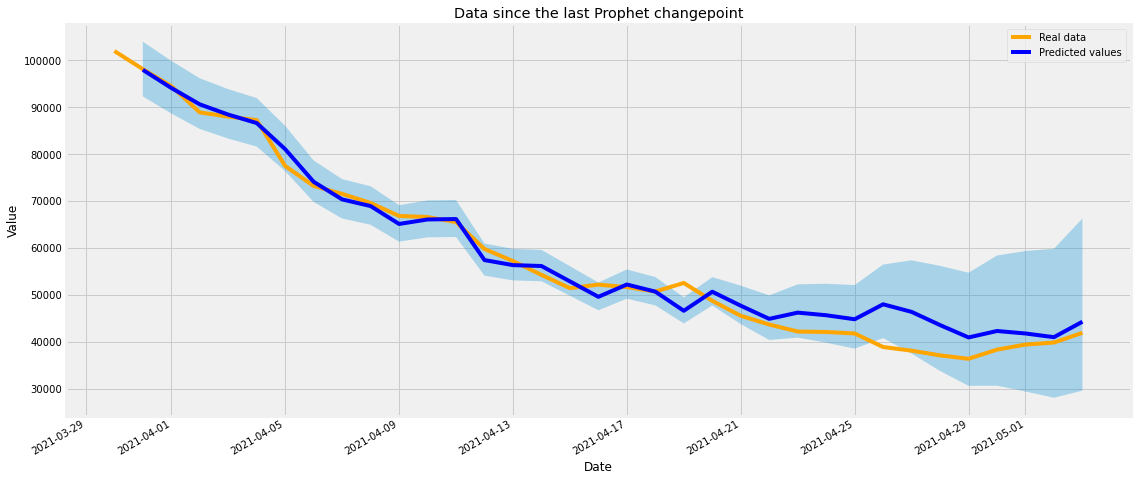

MAPE on train data =  3.62 % 
MAPE on test data =  8.95 %


In [52]:
f_steps = 14
window=-35
preds = sarima_ccc.get_prediction(start=1, end=len(active_box[changepoint:-14]) + f_steps, dynamic=False)
preds_df = preds.summary_frame()
preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']] = preds_df[['mean','mean_se', 'mean_ci_lower', 'mean_ci_upper']].apply(lambda x : log_transform(x, inverse=True))

fig, ax = plt.subplots(figsize=(17, 8))

plt.plot(active['ds'][window:], active['y'][window:], label='Real data', color='orange')
preds_df['ds'] = active['ds']
preds_df.set_index('ds')['mean'][window:].plot(ax=ax, label='Predicted values', color='blue')

ax.fill_between(preds_df['ds'][window:], preds_df['mean_ci_lower'][window:], preds_df['mean_ci_upper'][window:], alpha=0.3)

plt.title('Data since the last Prophet changepoint')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig('../figures/sarima_forecast_active_cp.png')
plt.show()

y_train_pred = preds_df['mean'][-40:-14]
y_train = active['y'][-40:-14]

y_test_pred = preds_df['mean'][-14:]
y_test = active['y'][-14:]

print(f'MAPE on train data = {mape(y_train, y_train_pred): .2f} % \nMAPE on test data = {mape(y_test, y_test_pred): .2f} %')